# BIBLIOTECAS

In [ ]:
import pandas as pd
import numpy as np
import yaml

from IPython.core.display   import HTML
from IPython.display        import Image

from scipy import  stats as ss
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn import metrics
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder
plt.rcParams["figure.figsize"]=12,8

pd.set_option('display.max_columns',30)

# FUNCOES AUXILIARES

In [ ]:
def import_config(path_yaml):
    with open(path_yaml) as config_file:
        config = yaml.safe_load(config_file)
    return config


def reamostrar_lr(df, frac):

    x_train_2, x_test_2 = train_test_split(df, test_size = config['split']['test_size'], random_state=config['split']['seed'], stratify=df9_lr['pago'])

    sample = x_train_2[x_train_2['pago']==0].sample(frac=frac, random_state=config['split']['seed'])
    x_train_2 = x_train_2.drop(sample.index)
    print(x_train_2['pago'].value_counts(normalize=True))

    x_train = x_train_2.drop('pago', axis=1)
    y_train = x_train_2['pago']

    y_test = x_test_2['pago']

    return x_train, x_train_2, x_test_2.drop('pago', axis=1), y_test


def cramers_v(confusion_matrix):

    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


def fs_kbest(x_train, y_train, x_test, y_test, model):
    k_vs_score_0 = []
    k_vs_score_1 = []

    for k in range(1, len(x_test.columns) + 1, 1):
        selector = SelectKBest(score_func=f_classif, k=k)

        Xtrain2 = selector.fit_transform(x_train, y_train)
        Xval2 = selector.transform(x_test)

        model.fit(Xtrain2, y_train)

        p = model.predict(Xval2)

        score_0 = round(metrics.f1_score(y_test, p, average=None)[0],3)
        score_1 = round(metrics.f1_score(y_test, p, average=None)[1],3)

        print("k= {} 0 F1_0 = {} - F1_1 = {}".format(k, score_0, score_1))
        k_vs_score_0.append(score_0)
        k_vs_score_1.append(score_1)

    pd.Series(k_vs_score_0, index=range(1, len(x_train.columns)+1,1)).plot(figsize=(10,7))
    pd.Series(k_vs_score_1, index=range(1, len(x_train.columns)+1,1)).plot(figsize=(10,7))

    plt.title('VISUALIZING METRIC', fontsize=10, weight='bold')
    plt.ylabel("F1 SCORE", fontsize=10, weight='bold')
    plt.xlabel("QTD FEATURES", fontsize=10, weight='bold')

    plt.show()

    selector = SelectKBest(score_func = f_classif, k=len(x_train.columns))
    selector.fit(x_train, y_train)

    pd.Series(selector.scores_, index=x_train.columns).sort_values().plot.barh()

    plt.show()

    df_score = pd.DataFrame({'variavel':x_train.columns, 'fs_score':selector.scores_, 'p_value': selector.pvalues_})
    df_score = df_score.sort_values('fs_score', ascending=False).reset_index(drop=True)
    display(df_score)


# 1.0 IMPORT DATA AND CONFIG

## 1.1 CONFIG

In [ ]:
config = import_config('config.yaml')

In [ ]:
config

{'split': {'seed': 42, 'test_size': 0.2},
 'data': {'raw_path': '../data/raw_data/raw_data.csv',
  'trusted_path': '../data/trusted_data/trusted_data.csv',
  'train_path': '../data/train_data/train_data.csv',
  'test_path': '../data/test_data/test_data.csv'},
 'imagem': {'path': '../imagens/mind map.png'}}

In [ ]:
config['data']['raw_path']

'../data/raw_data/raw_data.csv'

## 1.2 DATA

In [ ]:
df1 = pd.read_csv(config['data']['raw_path'])

In [ ]:
df1.head()

,escolaridade,renda_mensal_informal,dependentes,estado_civil,idade,conta_poupanca,conta_salario,qtd_fonte_renda,cheque_sem_fundo,conta_conjunta,valor_conta_corrente,valor_conta_poupanca,valor_emprestimo,multa,juros,valor_emprestimo_atualizado,pago,id,genero,data,estado
0,NaN,NaN,S,solteiro,36,S,N,NaN,S,N,NaN,NaN,8174.32,263.25,5844.98,14282.55,sim,309652396,feminino,2020-01-01,minas gerais
1,nivel medio,1894.5078,N,solteiro,39,S,N,1.0,N,N,NaN,NaN,41775.63,1607.29,7652.26,51035.18,sim,498764591,feminino,2020-01-01,espirito santo
2,nivel medio,NaN,S,solteiro,26,S,N,1.0,N,N,NaN,NaN,522940.27,24860.40,319315.62,867116.29,sim,504868288,masculino,2020-01-01,sao paulo
3,NaN,NaN,N,casado(a) com comunhao de bens,23,N,N,NaN,S,N,NaN,NaN,1418.00,21472.36,2967.48,25857.84,sim,541365315,feminino,2020-01-01,sao paulo
4,NaN,NaN,S,solteiro,33,S,N,NaN,S,N,NaN,NaN,2078.97,19.44,46.35,2144.76,sim,563622907,masculino,2020-01-01,espirito santo


# 2.0 DATA CLEAN

In [ ]:
df2 = df1.copy()

## 2.1 DESCRICAO DOS DADOS

In [ ]:
df2.head()

,escolaridade,renda_mensal_informal,dependentes,estado_civil,idade,conta_poupanca,conta_salario,qtd_fonte_renda,cheque_sem_fundo,conta_conjunta,valor_conta_corrente,valor_conta_poupanca,valor_emprestimo,multa,juros,valor_emprestimo_atualizado,pago,id,genero,data,estado
0,NaN,NaN,S,solteiro,36,S,N,NaN,S,N,NaN,NaN,8174.32,263.25,5844.98,14282.55,sim,309652396,feminino,2020-01-01,minas gerais
1,nivel medio,1894.5078,N,solteiro,39,S,N,1.0,N,N,NaN,NaN,41775.63,1607.29,7652.26,51035.18,sim,498764591,feminino,2020-01-01,espirito santo
2,nivel medio,NaN,S,solteiro,26,S,N,1.0,N,N,NaN,NaN,522940.27,24860.40,319315.62,867116.29,sim,504868288,masculino,2020-01-01,sao paulo
3,NaN,NaN,N,casado(a) com comunhao de bens,23,N,N,NaN,S,N,NaN,NaN,1418.00,21472.36,2967.48,25857.84,sim,541365315,feminino,2020-01-01,sao paulo
4,NaN,NaN,S,solteiro,33,S,N,NaN,S,N,NaN,NaN,2078.97,19.44,46.35,2144.76,sim,563622907,masculino,2020-01-01,espirito santo


In [ ]:
df2.head().T

,0,1,2,3,4
escolaridade,NaN,nivel medio,nivel medio,NaN,NaN
renda_mensal_informal,NaN,1894.5078,NaN,NaN,NaN
dependentes,S,N,S,N,S
estado_civil,solteiro,solteiro,solteiro,casado(a) com comunhao de bens,solteiro
idade,36,39,26,23,33
conta_poupanca,S,S,S,N,S
conta_salario,N,N,N,N,N
qtd_fonte_renda,NaN,1.0,1.0,NaN,NaN
cheque_sem_fundo,S,N,N,S,S
conta_conjunta,N,N,N,N,N


## 2.2 DIMENSAO DOS DADOS

In [ ]:
df2.shape

(50390, 21)

## 2.3 TIPO DA COLUNA

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50390 entries, 0 to 50389
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   escolaridade                 14615 non-null  object 
 1   renda_mensal_informal        9768 non-null   float64
 2   dependentes                  50390 non-null  object 
 3   estado_civil                 50390 non-null  object 
 4   idade                        50390 non-null  int64  
 5   conta_poupanca               50390 non-null  object 
 6   conta_salario                50390 non-null  object 
 7   qtd_fonte_renda              12806 non-null  float64
 8   cheque_sem_fundo             50390 non-null  object 
 9   conta_conjunta               50390 non-null  object 
 10  valor_conta_corrente         0 non-null      float64
 11  valor_conta_poupanca         0 non-null      float64
 12  valor_emprestimo             50390 non-null  float64
 13  multa           

## 2.4 CHECAR NAN VALUES

In [ ]:
df2.isna().sum() / len(df2)

escolaridade                   0.709962
renda_mensal_informal          0.806152
dependentes                    0.000000
estado_civil                   0.000000
idade                          0.000000
conta_poupanca                 0.000000
conta_salario                  0.000000
qtd_fonte_renda                0.745862
cheque_sem_fundo               0.000000
conta_conjunta                 0.000000
valor_conta_corrente           1.000000
valor_conta_poupanca           1.000000
valor_emprestimo               0.000000
multa                          0.000000
juros                          0.000000
valor_emprestimo_atualizado    0.000000
pago                           0.000000
id                             0.000000
genero                         0.000000
data                           0.000000
estado                         0.000000
dtype: float64

## 2.5 DROPAR LINHAS DUPLICADAS

In [ ]:
df2.shape

(50390, 21)

In [ ]:
df2.drop_duplicates().shape

(50390, 21)

## 2.6 MUDAR TIPO DA VARIAVEL

In [ ]:
df2['data'] = df2['data'].astype('datetime64[ns]')

## 2.7 DROPAR COLUNAS

In [ ]:
# 100% vazio nao tem como trabalhar o dado
df2= df2.drop(['valor_conta_corrente', 'valor_conta_poupanca'], axis=1)

df2= df2.drop(['escolaridade', 'renda_mensal_informal', 'qtd_fonte_renda', 'data'], axis=1)

## 2.8 ESTATISCA DESCRITIVA

In [ ]:
num_attributes = df2.select_dtypes(include=['int32', 'int64', 'float32', 'float64'])

cat_attributes = df2.select_dtypes(exclude=['int32', 'int64', 'float32', 'float64', 'datetime64[ns]'])

### 2.8.1 VARIAVEIS NUMERICAS

In [ ]:
#Tendencia central - mean, median

ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame ( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame ( num_attributes.apply( min ) ).T
d3 = pd.DataFrame ( num_attributes.apply( max ) ).T
d4 = pd.DataFrame ( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame ( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame ( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ( [ 'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

m.head()

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,idade,18.00,1.130000e+02,9.500000e+01,31.724529,30.000,8.565032e+00,1.959951,7.223175
1,valor_emprestimo,1393.00,2.867894e+08,2.867880e+08,51988.873901,2298.035,1.588803e+06,135.859233,22605.724510
2,multa,0.00,5.737759e+08,5.737759e+08,60226.580975,648.965,2.843913e+06,171.305766,33333.600930
3,juros,0.00,5.703619e+08,5.703619e+08,64853.905193,1143.320,2.728143e+06,184.431138,38002.805365
4,valor_emprestimo_atualizado,1397.04,1.430927e+09,1.430926e+09,177069.360068,5652.695,7.058294e+06,171.822788,33820.743108


In [ ]:
num_attributes.describe(percentiles=[0.99, 0.95, 0.75, 0.5]).T

,count,mean,std,min,50%,75%,95%,99%,max
idade,50390.0,3.172453e+01,8.565117e+00,1.800000e+01,3.000000e+01,3.500000e+01,4.800000e+01,6.200000e+01,1.130000e+02
valor_emprestimo,50390.0,5.198887e+04,1.588819e+06,1.393000e+03,2.298035e+03,7.172175e+03,5.879202e+04,4.464769e+05,2.867894e+08
multa,50390.0,6.022658e+04,2.843941e+06,0.000000e+00,6.489650e+02,3.600000e+03,6.189092e+04,5.039267e+05,5.737759e+08
juros,50390.0,6.485391e+04,2.728170e+06,0.000000e+00,1.143320e+03,5.545427e+03,8.235361e+04,6.408426e+05,5.703619e+08
valor_emprestimo_atualizado,50390.0,1.770694e+05,7.058364e+06,1.397040e+03,5.652695e+03,1.903061e+04,2.006742e+05,1.586720e+06,1.430927e+09
id,50390.0,5.485969e+08,2.601500e+08,1.000172e+08,5.482058e+08,7.737146e+08,9.542667e+08,9.912031e+08,9.999988e+08


### 2.8.2 VARAIVEIS CATEGORIAS

In [ ]:
for i in cat_attributes.columns:
     print(cat_attributes[i].value_counts(normalize=True))
     print('==========================================\n\n')

dependentes
N    0.639968
S    0.360032
Name: proportion, dtype: float64


estado_civil
solteiro                                  0.547053
casado(a) com comunhao parcial de bens    0.263604
casado(a) com comunhao de bens            0.154098
casado(a) com separacao de bens           0.030959
separado judicialmente                    0.001469
divorciado                                0.001330
viuvo(a)                                  0.000814
outros                                    0.000675
Name: proportion, dtype: float64


conta_poupanca
S    0.847986
N    0.152014
Name: proportion, dtype: float64


conta_salario
N    0.976603
S    0.023397
Name: proportion, dtype: float64


cheque_sem_fundo
S    0.769974
N    0.230026
Name: proportion, dtype: float64


conta_conjunta
N    0.958285
S    0.041715
Name: proportion, dtype: float64


pago
sim    0.790891
nao    0.209109
Name: proportion, dtype: float64


genero
masculino    0.501667
feminino     0.498333
Name: proportion, dtype: float64


# 3.0 MIND MAP E ENGENHARIA DE VARIAVEIS

In [ ]:
df3 = df2.copy()

## 3.1 MIND MAP

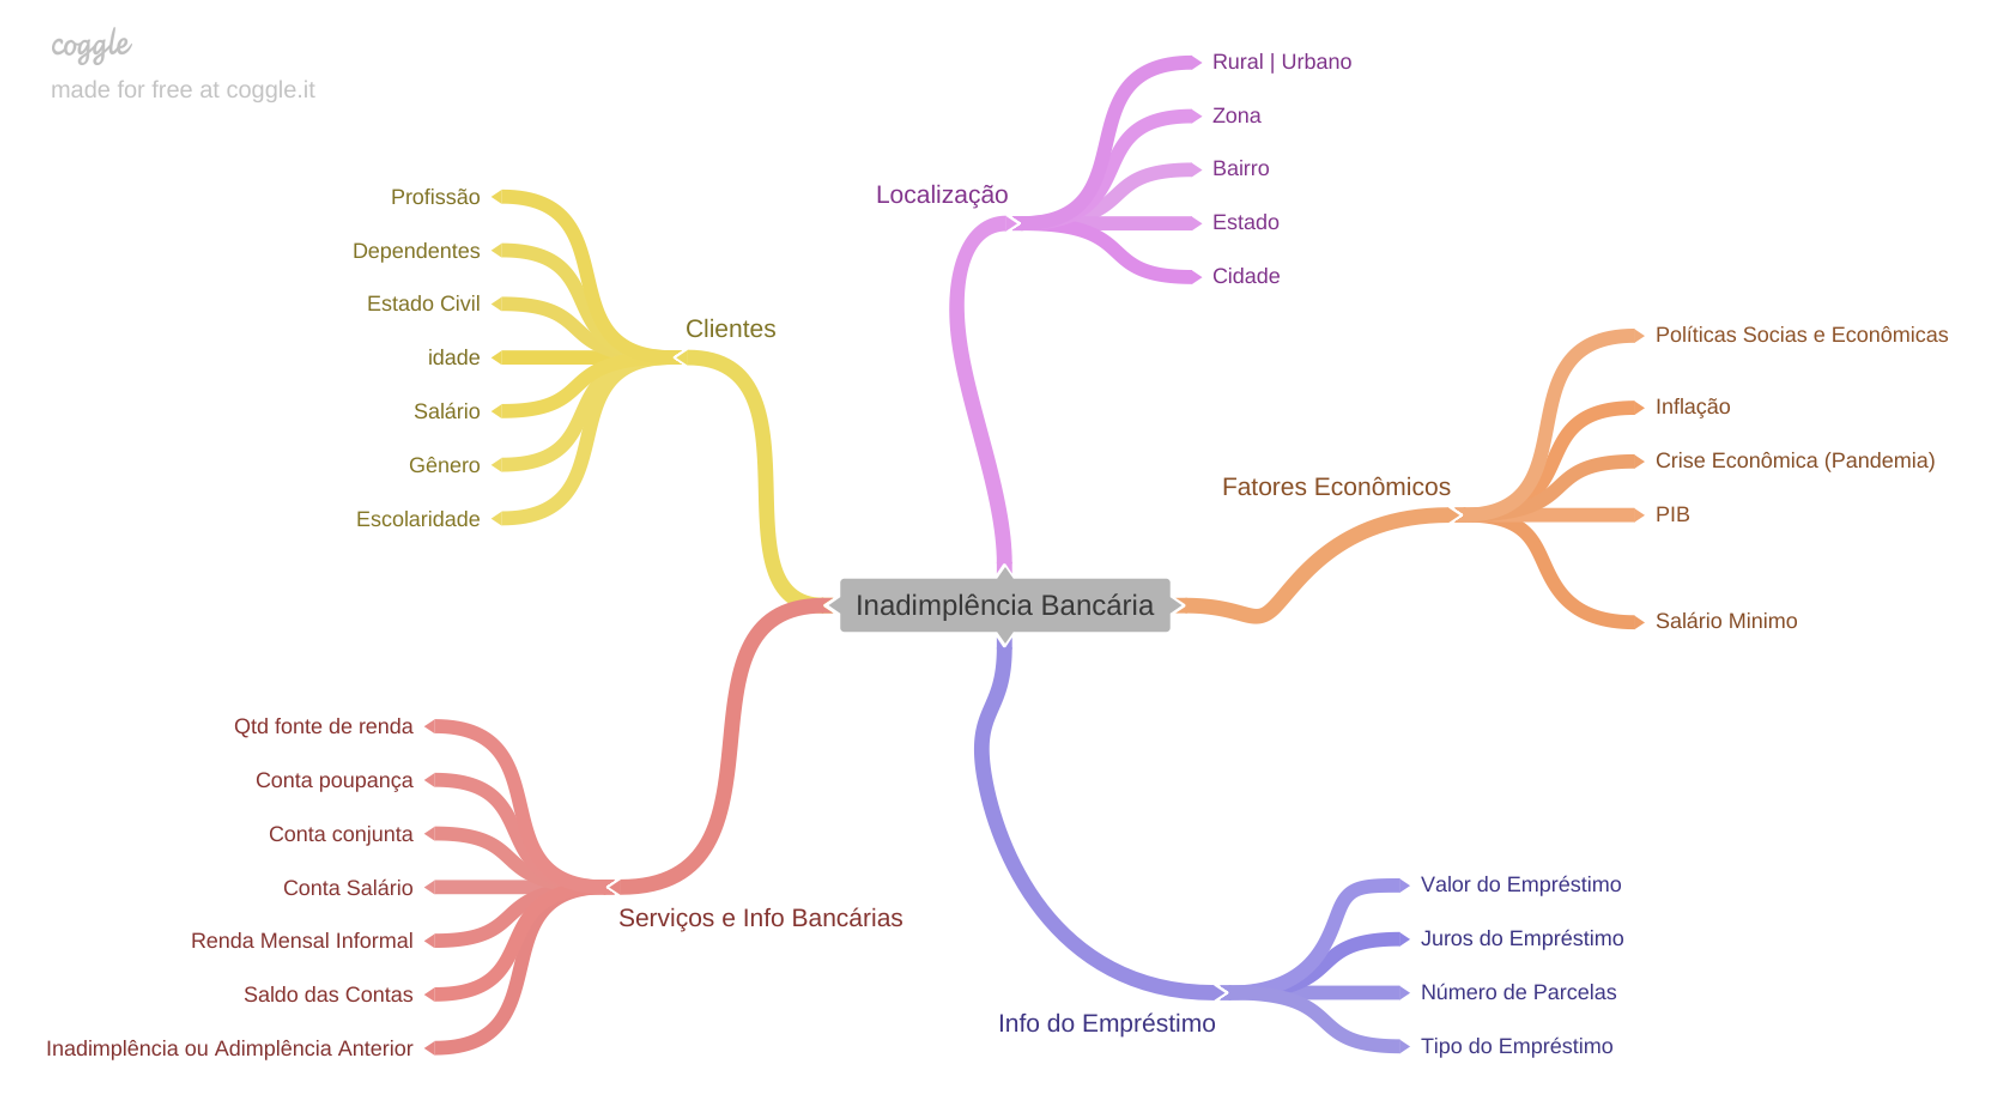

In [ ]:
Image(config['imagem']['path'])

### Hipóteses de Informações dos Clientes

**1.** Mulheres são em média 10% mais ADIMPLENTES.

**2.** Clientes com Menos de 60 anos são em média 20% mais ADIMPLENTES.

**3.** Clientes com Dependentes são em média 15% mais ADIMPLENTES.

**4.** Clientes que são solteiros tem uma taxa percentual maior de INADIMPLÊNCIA que os demais.

### Hipóteses de Informações Bancárias

**5.** Clientes com conta salário são em média 30% mais ADIMPLENTES.

**6.** Clientes com conta poupança são em média 10% mais ADIMPLENTES.

**7.** Clientes que já passaram cheque sem fundo são em média 15% mais INADIMPLENTES.

**8.** Clientes que tem conta conjunta são em média 10% mais INADIMPLENTES.

### Hipóteses de Informações do Empréstimo

**9.** Clientes que pegaram empréstimos de mais de RS$20000 tem tendência a ser INADIMPLENTES.

### Hipóteses de Informações de Localização

**10.** Clientes que moram no Estado RJ E SP tem maior percentual de ADIMPLENTE do que ES e MG.

## 3.2 ENGENHARIA DE VARIAVEIS

In [ ]:
df3['juros_porcentagem'] = df3['juros']/df3['valor_emprestimo']

# 4.0 EDA UNIVARIDA

In [ ]:
df4 = df3.copy()

## 4.1 NUMERICA

In [ ]:
num_attributes = df4.select_dtypes(include=['int32', 'int64', 'float32', 'float64'])

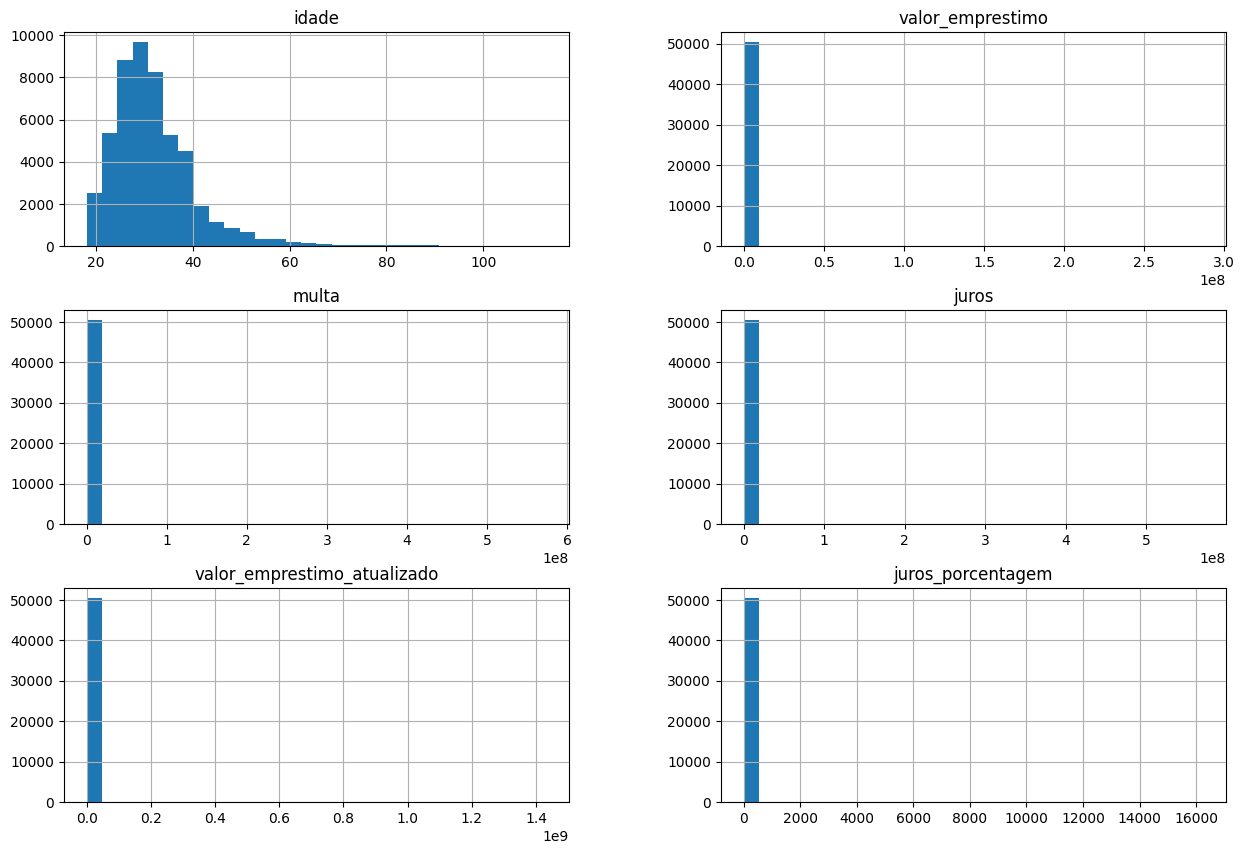

In [ ]:
num_attributes.drop('id', axis=1).hist(bins=30, figsize=(15,10));

### 4.1.1 IDADE

count    50390.000000
mean        31.724529
std          8.565117
min         18.000000
25%         26.000000
50%         30.000000
75%         35.000000
max        113.000000
Name: idade, dtype: float64


Text(0.5, 1.0, 'boxplot')

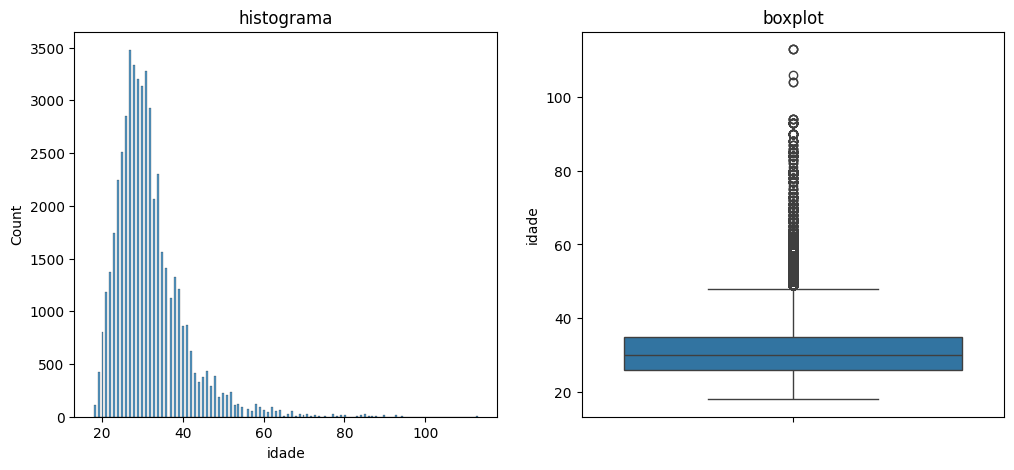

In [ ]:
print(df4['idade'].describe())
fig, axes = plt.subplots(1,2 ,figsize=(12,5))

sns.histplot(df4['idade'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['idade'], ax=axes[1])
axes[1].set_title('boxplot')

### 4.1.2 VALOR DO EMPRESTIMO

count    5.039000e+04
mean     5.198887e+04
std      1.588819e+06
min      1.393000e+03
25%      1.622370e+03
50%      2.298035e+03
75%      7.172175e+03
max      2.867894e+08
Name: valor_emprestimo, dtype: float64


Text(0.5, 1.0, 'boxplot')

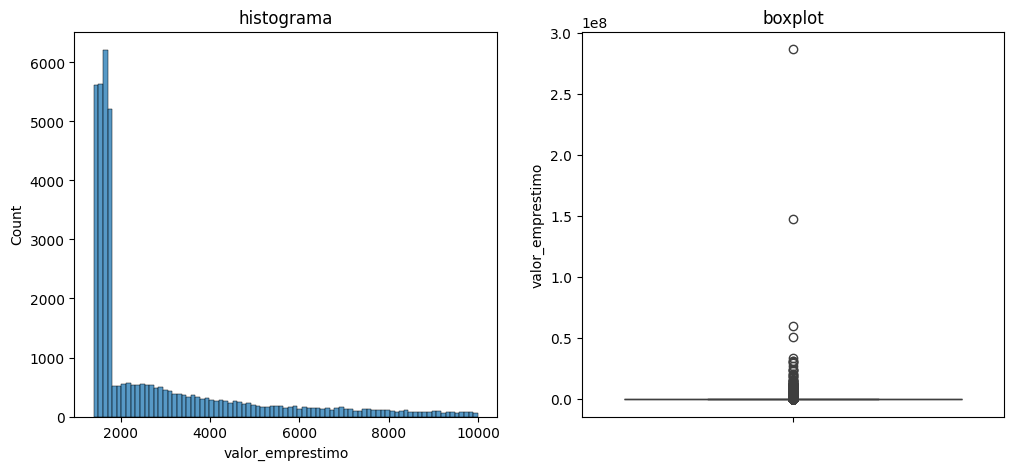

In [ ]:
print(df4['valor_emprestimo'].describe())
fig, axes = plt.subplots(1,2 ,figsize=(12,5))

sns.histplot(df4[df4['valor_emprestimo']<10000]['valor_emprestimo'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['valor_emprestimo'], ax=axes[1])
axes[1].set_title('boxplot')

### 4.1.3 MULTA

count    5.039000e+04
mean     6.022658e+04
std      2.843941e+06
min      0.000000e+00
25%      1.325675e+02
50%      6.489650e+02
75%      3.600000e+03
max      5.737759e+08
Name: multa, dtype: float64


Text(0.5, 1.0, 'boxplot')

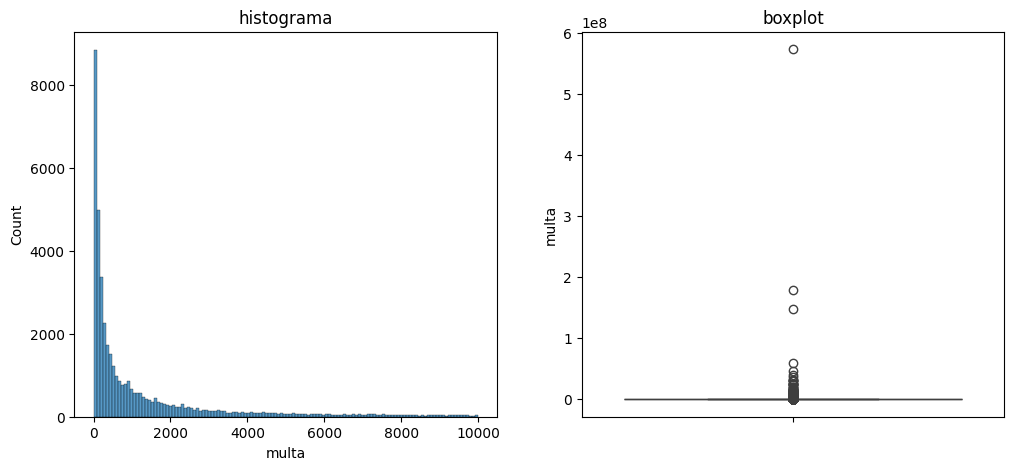

In [ ]:
print(df4['multa'].describe())
fig, axes = plt.subplots(1,2 ,figsize=(12,5))

sns.histplot(df4[df4['multa']<10000]['multa'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['multa'], ax=axes[1])
axes[1].set_title('boxplot')

### 4.1.4 JUROS

count    5.039000e+04
mean     6.485391e+04
std      2.728170e+06
min      0.000000e+00
25%      2.742725e+02
50%      1.143320e+03
75%      5.545427e+03
max      5.703619e+08
Name: juros, dtype: float64


Text(0.5, 1.0, 'boxplot')

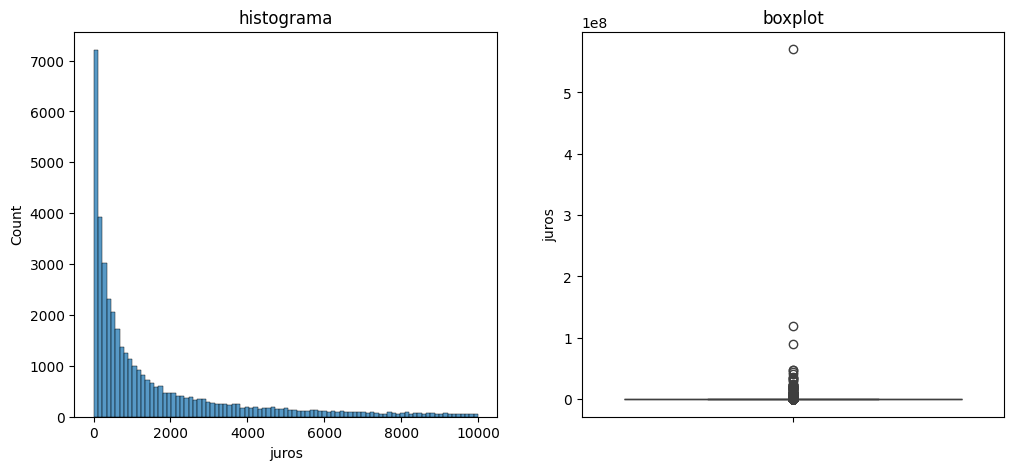

In [ ]:
print(df4['juros'].describe())
fig, axes = plt.subplots(1,2 ,figsize=(12,5))

sns.histplot(df4[df4['juros']<10000]['juros'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['juros'], ax=axes[1])
axes[1].set_title('boxplot')

### 4.1.5 VALOR DO EMPRESTIMO ATUALIZADO

count    5.039000e+04
mean     1.770694e+05
std      7.058364e+06
min      1.397040e+03
25%      2.842910e+03
50%      5.652695e+03
75%      1.903061e+04
max      1.430927e+09
Name: valor_emprestimo_atualizado, dtype: float64


Text(0.5, 1.0, 'boxplot')

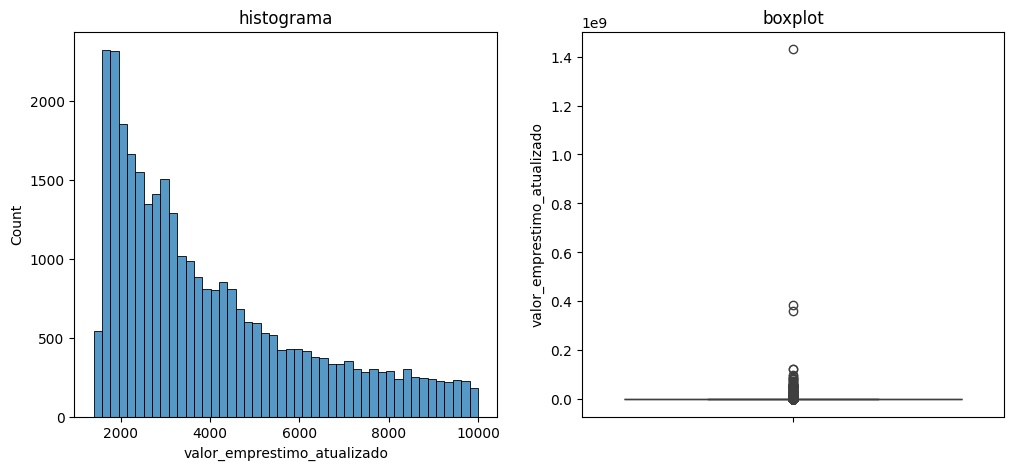

In [ ]:
print(df4['valor_emprestimo_atualizado'].describe())
fig, axes = plt.subplots(1,2 ,figsize=(12,5))

sns.histplot(df4[df4['valor_emprestimo_atualizado']<10000]['valor_emprestimo_atualizado'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['valor_emprestimo_atualizado'], ax=axes[1])
axes[1].set_title('boxplot')

### 4.1.6 JUROS PORCENTAGEM

count    50390.000000
mean         3.029730
std        105.423189
min          0.000000
25%          0.112590
50%          0.349677
75%          0.848668
max      16248.020882
Name: juros_porcentagem, dtype: float64


Text(0.5, 1.0, 'boxplot')

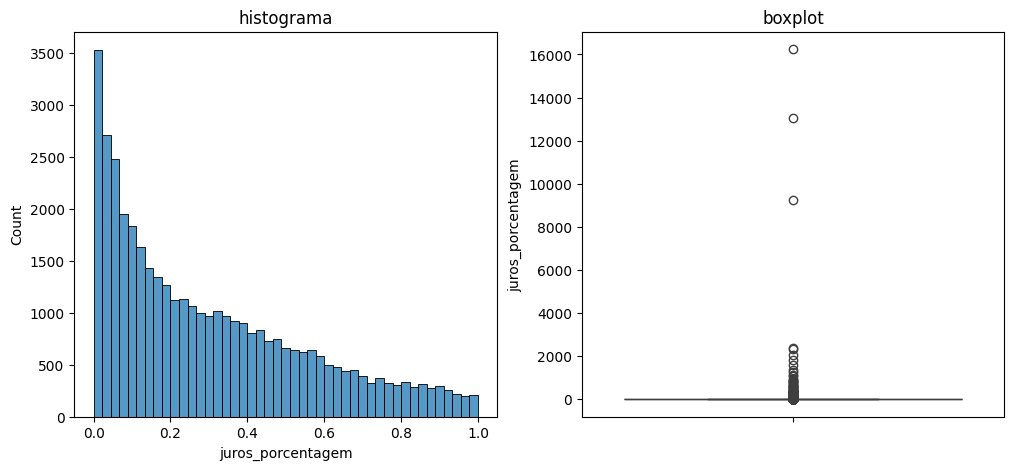

In [ ]:
print(df4['juros_porcentagem'].describe())
fig, axes = plt.subplots(1,2 ,figsize=(12,5))

sns.histplot(df4[df4['juros_porcentagem']<1]['juros_porcentagem'], ax=axes[0])
axes[0].set_title('histograma')

sns.boxplot(df4['juros_porcentagem'], ax=axes[1])
axes[1].set_title('boxplot')

## 4.2 CATEGORICAS

### 4.2.1 DENPENDETES

dependentes
N    0.639968
S    0.360032
Name: proportion, dtype: float64


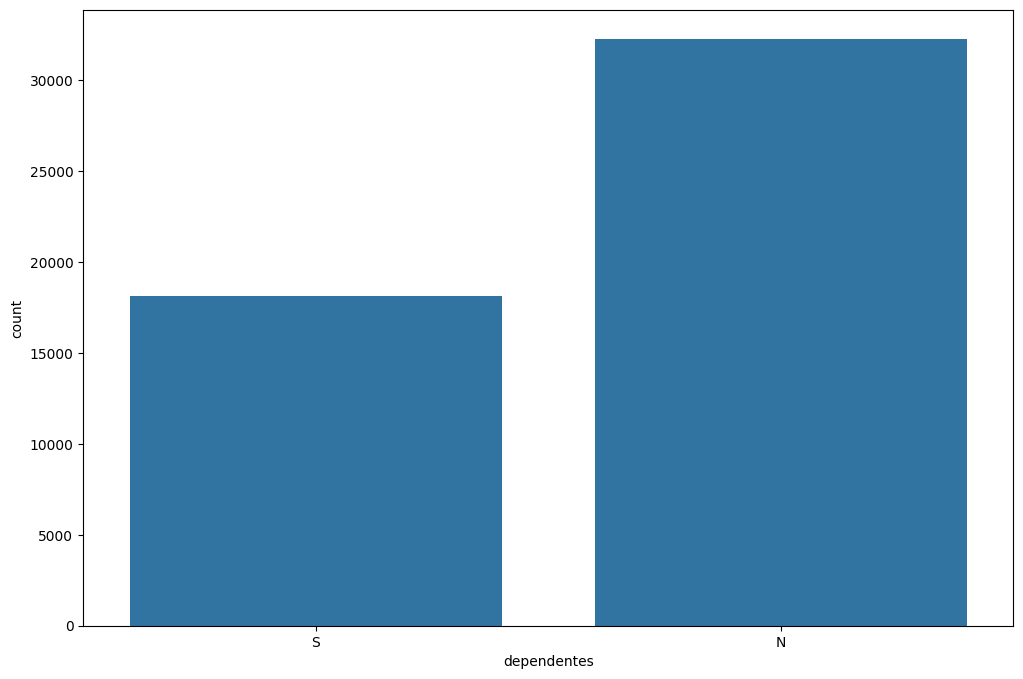

In [ ]:
print(df4['dependentes'].value_counts(normalize=True))
sns.countplot(x='dependentes', data=df4);

### 4.2.2 ESTADO CIVIL

estado_civil
solteiro                                  0.547053
casado(a) com comunhao parcial de bens    0.263604
casado(a) com comunhao de bens            0.154098
casado(a) com separacao de bens           0.030959
separado judicialmente                    0.001469
divorciado                                0.001330
viuvo(a)                                  0.000814
outros                                    0.000675
Name: proportion, dtype: float64


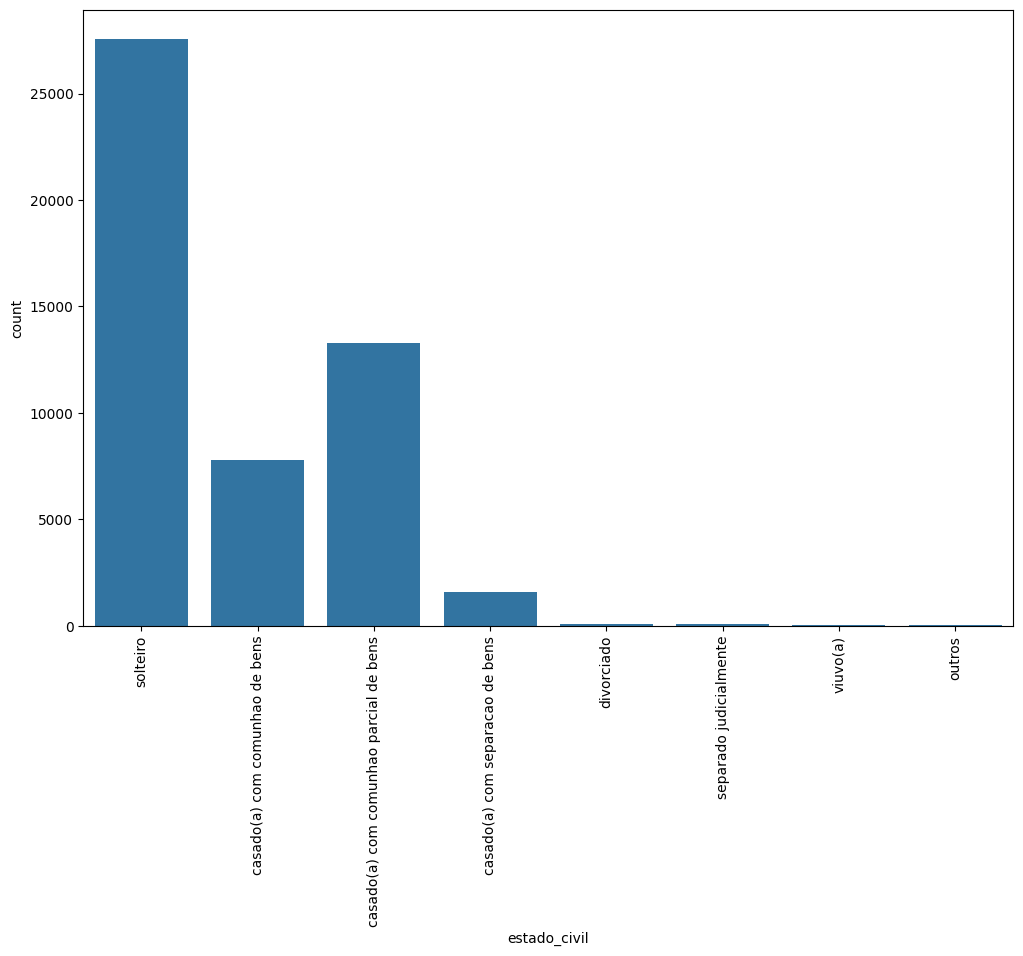

In [ ]:
print(df4['estado_civil'].value_counts(normalize=True))
sns.countplot(x='estado_civil', data=df4);
plt.xticks(rotation=90);

### 4.2.3 CONTA POUPANCA

conta_poupanca
S    0.847986
N    0.152014
Name: proportion, dtype: float64


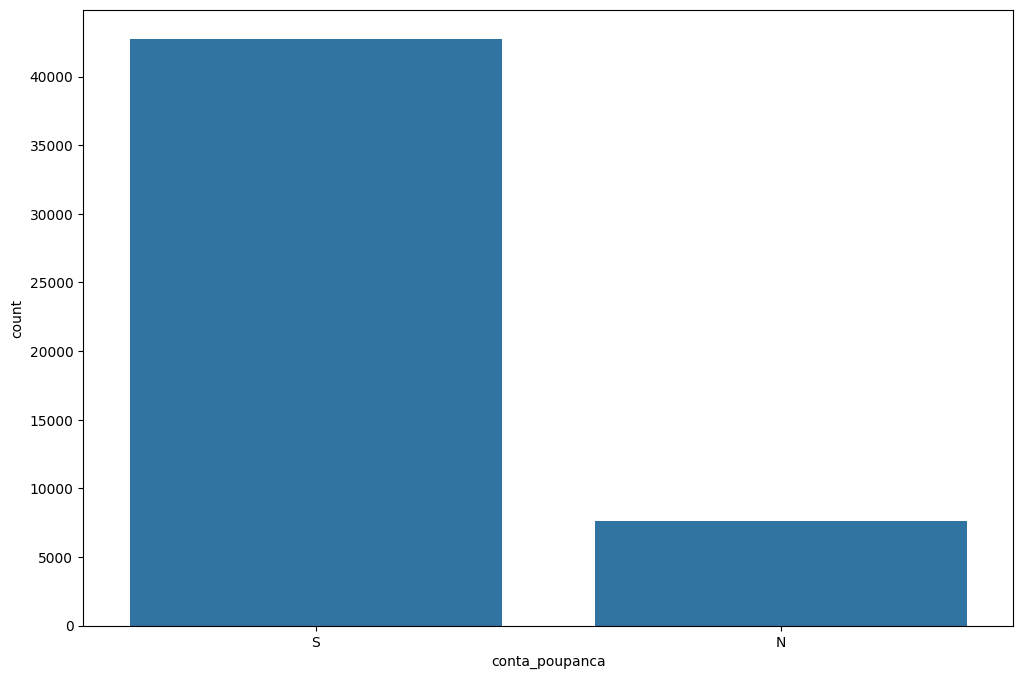

In [ ]:
print(df4['conta_poupanca'].value_counts(normalize=True))
sns.countplot(x='conta_poupanca', data=df4);

### 4.2.4 CONTA SALARIO

conta_salario
N    0.976603
S    0.023397
Name: proportion, dtype: float64


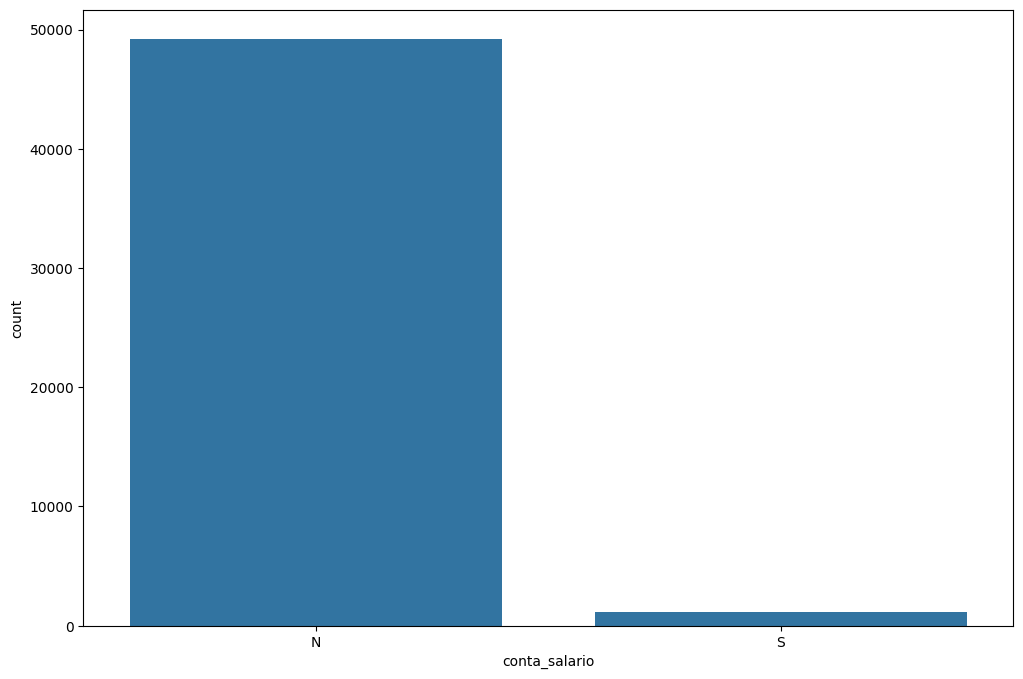

In [ ]:
print(df4['conta_salario'].value_counts(normalize=True))
sns.countplot(x='conta_salario', data=df4);

### 4.2.5 CHEQUE SEM FUNDO

cheque_sem_fundo
S    0.769974
N    0.230026
Name: proportion, dtype: float64


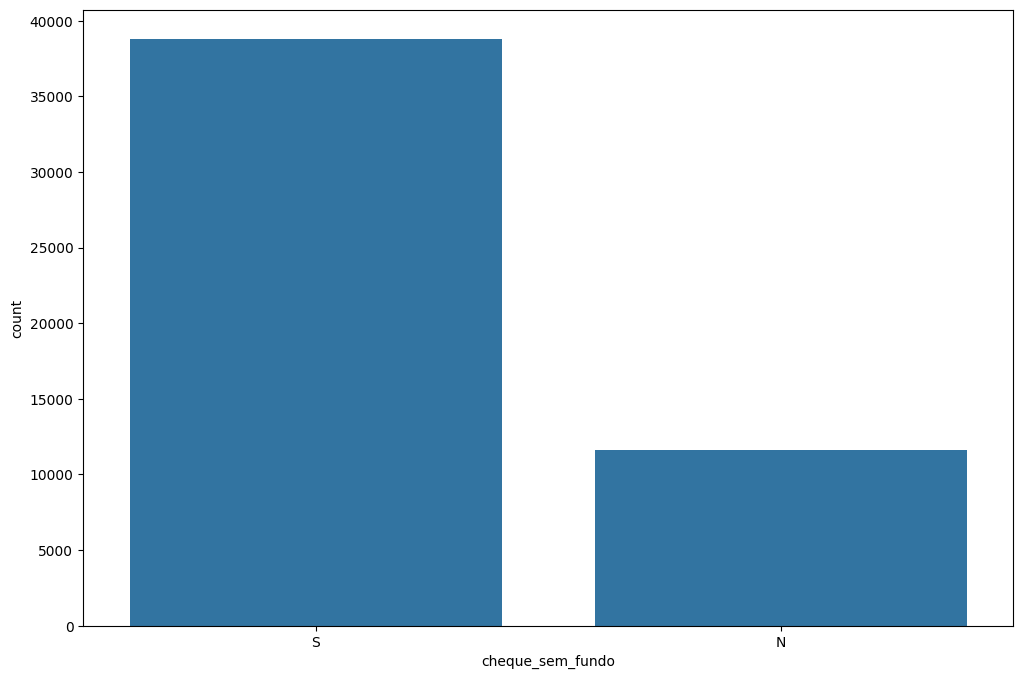

In [ ]:
print(df4['cheque_sem_fundo'].value_counts(normalize=True))
sns.countplot(x='cheque_sem_fundo', data=df4);

### 4.2.6 CONTA CONJUNTA

conta_conjunta
N    0.958285
S    0.041715
Name: proportion, dtype: float64


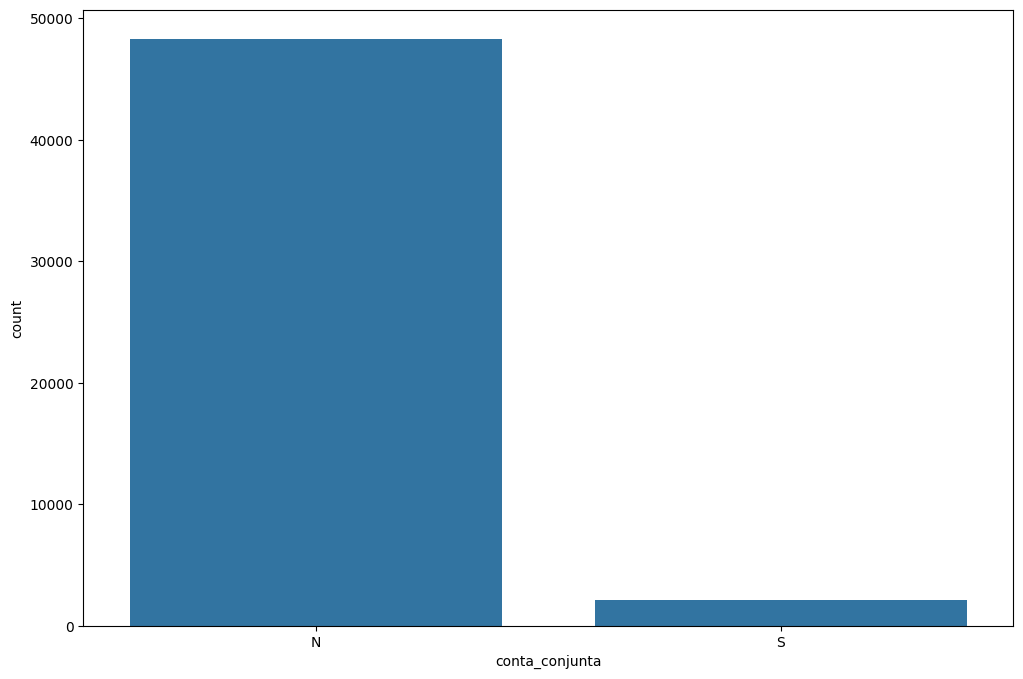

In [ ]:
print(df4['conta_conjunta'].value_counts(normalize=True))
sns.countplot(x='conta_conjunta', data=df4);

### 4.2.7 PAGO

pago
sim    0.790891
nao    0.209109
Name: proportion, dtype: float64


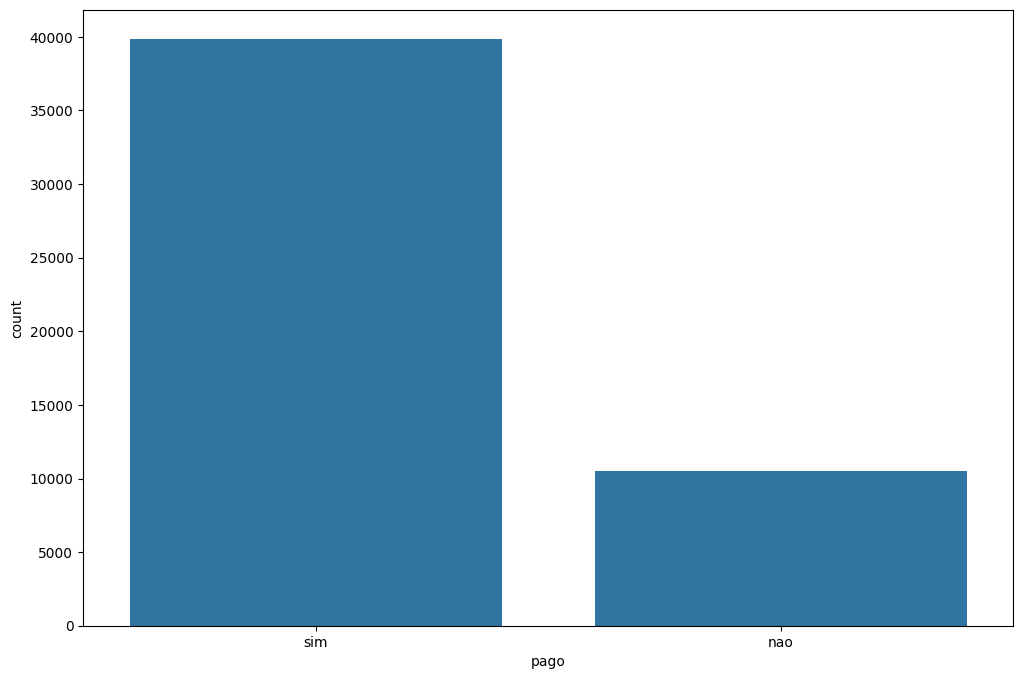

In [ ]:
print(df4['pago'].value_counts(normalize=True))
sns.countplot(x='pago', data=df4);

### 4.2.8 GENERO

genero
masculino    0.501667
feminino     0.498333
Name: proportion, dtype: float64


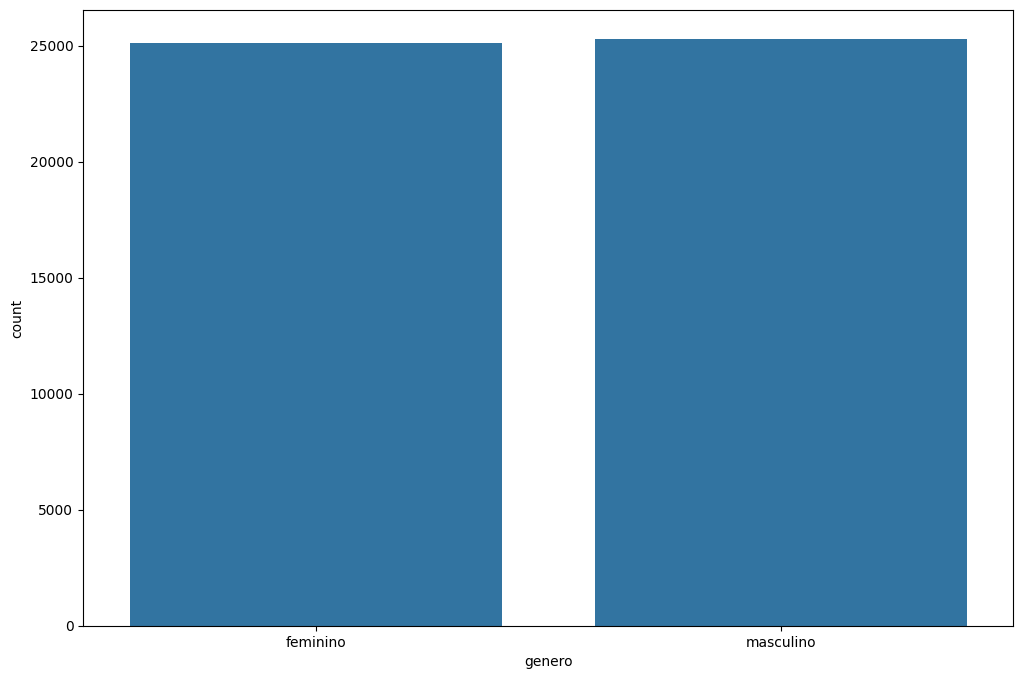

In [ ]:
print(df4['genero'].value_counts(normalize=True))
sns.countplot(x='genero', data=df4);

### 4.2.9 ESTADO

estado
minas gerais      0.251340
sao paulo         0.250189
espirito santo    0.249772
rio de janeiro    0.248700
Name: proportion, dtype: float64


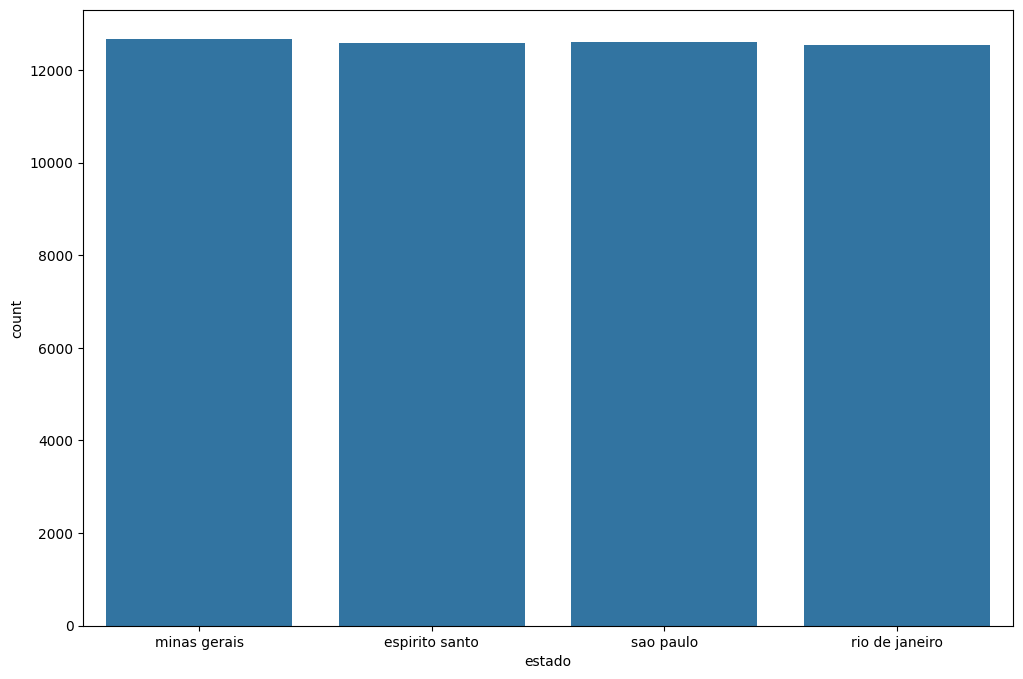

In [ ]:
print(df4['estado'].value_counts(normalize=True))
sns.countplot(x='estado', data=df4);

# 5.0 CLEAN OUTLIERS

In [ ]:
df5 = df4.copy()

In [ ]:
df5['pago'].value_counts(normalize=True)

pago
sim    0.790891
nao    0.209109
Name: proportion, dtype: float64

In [ ]:
len(df5[df5['valor_emprestimo']>5000000]) / len(df5)

0.0015479261758285373

In [ ]:
len(df5[df5['juros_porcentagem']<0.01]) / len(df5)

0.03464973208970034

In [ ]:
df5 = df5[df5['valor_emprestimo']<5000000].copy()
df5 = df5[df5['juros_porcentagem']>0.01].copy()

In [ ]:
df5['pago'].value_counts(normalize=True)

pago
sim    0.787073
nao    0.212927
Name: proportion, dtype: float64

In [ ]:
config

{'data': {'raw_path': '../data/raw_data/raw_data.csv',
  'trusted_path': '../data/trusted_data/trusted_data.csv'},
 'imagem': {'path': '../imagens/mind map.png'}}

In [ ]:
df5.to_csv(config['data']['trusted_path'], index=False)

# 6.0 EDA BIVARIADA

In [ ]:
df6 = pd.read_csv(config['data']['trusted_path'])

## 6.1 GENERO (Mulheres são em média 10% mais ADIMPLENTES.) (FALSO)

pago,nao,sim
genero,,
feminino,5220,18992
masculino,5121,19233


pago,nao,sim
genero,,
feminino,0.215596,0.784404
masculino,0.210273,0.789727


<Axes: xlabel='genero'>

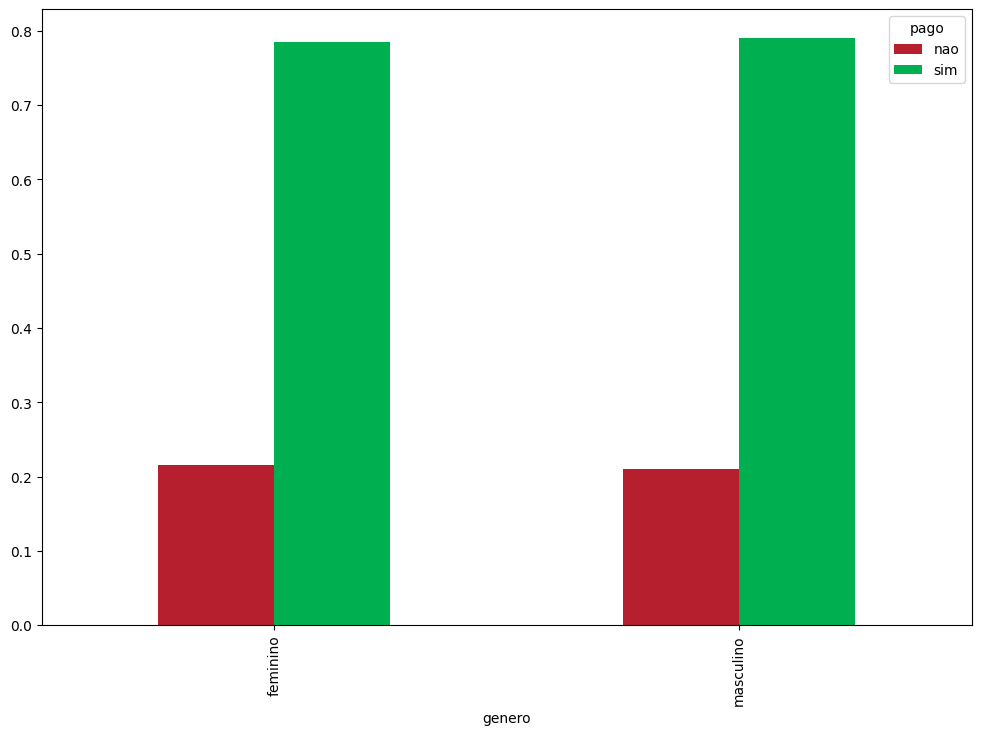

In [ ]:
display(pd.crosstab(df6['genero'],df6['pago']))

display(pd.crosstab(df6['genero'],df6['pago'], normalize='index'))

display(pd.crosstab(df6['genero'],df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim': '#00b050'}))

## 6.2 IDADE (Clientes com Menos de 60 anos são em média 20% mais ADIMPLENTES.) (FALSO)

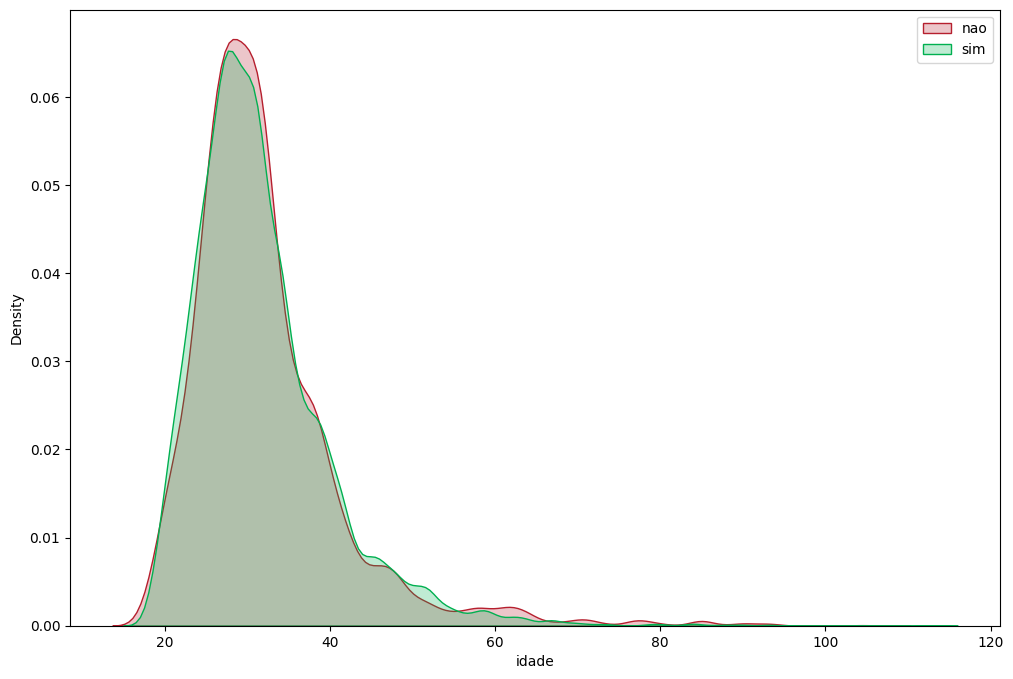

In [ ]:
sns.kdeplot(df6[df6['pago']=='nao']['idade'], label='nao', fill=True, color='#b61f2e')
sns.kdeplot(df6[df6['pago']=='sim']['idade'], label='sim', fill=True, color='#00b050')
plt.legend();

## 6.3 DEPENDENTES (Clientes com Dependentes são em média 15% mais ADIMPLENTES.) (VERDADEIRA)

pago,nao,sim
idade_binned,,
"(18, 38]",8715,32015
"(38, 58]",1345,5649
"(58, 78]",193,408
"(78, 98]",46,80


pago,nao,sim
idade_binned,,
"(18, 38]",0.213970,0.786030
"(38, 58]",0.192308,0.807692
"(58, 78]",0.321131,0.678869
"(78, 98]",0.365079,0.634921


<Axes: xlabel='idade_binned'>

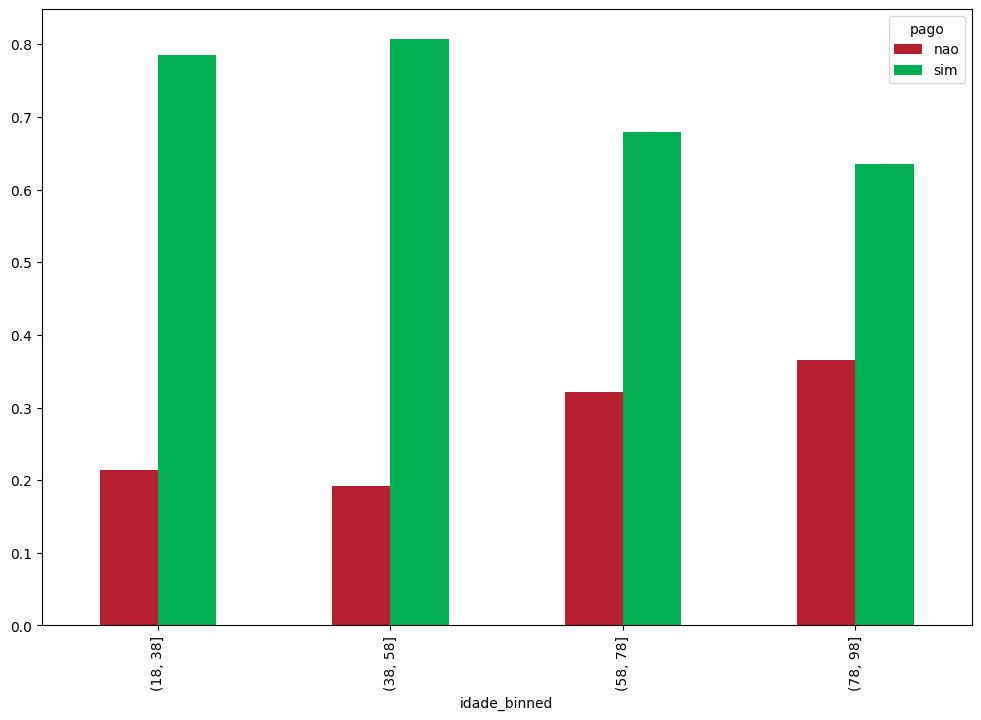

In [ ]:
bins = list(np.arange(18,113,20))
aux = df6.copy()

aux['idade_binned']= pd.cut(aux['idade'],bins=bins)


display(pd.crosstab(aux['idade_binned'],aux['pago']))
display(pd.crosstab(aux['idade_binned'],aux['pago'], normalize='index'))
display(pd.crosstab(aux['idade_binned'],aux['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim': '#00b050'}))

pago,nao,sim
dependentes,,
N,8661,22568
S,1680,15657


pago,nao,sim
dependentes,,
N,0.277338,0.722662
S,0.096903,0.903097


<Axes: xlabel='dependentes'>

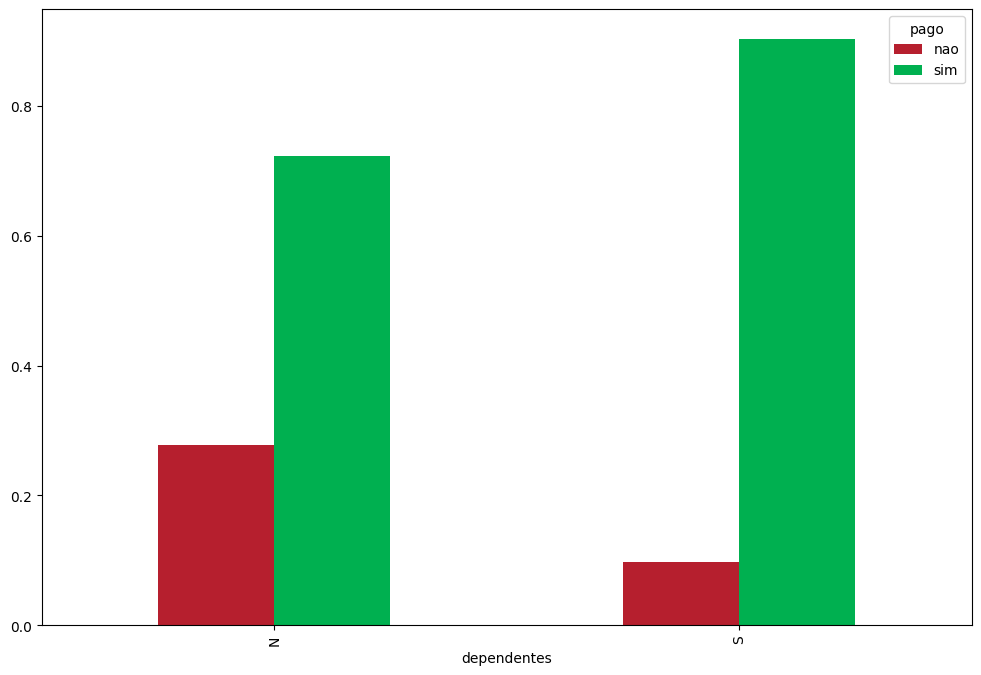

In [ ]:
display(pd.crosstab(df6['dependentes'],df6['pago']))
display(pd.crosstab(df6['dependentes'],df6['pago'], normalize='index'))
display(pd.crosstab(df6['dependentes'],df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim': '#00b050'}))

## 6.4 ESTADO CIVIL (Clientes que são solteiros tem uma taxa percentual maior de INADIMPLÊNCIA que os demais.) (FALSO)

pago,nao,sim
estado_civil,,
casado(a) com comunhao de bens,1790,5825
casado(a) com comunhao parcial de bens,5112,8003
casado(a) com separacao de bens,401,1105
divorciado,6,56
outros,27,7
separado judicialmente,33,41
solteiro,2949,23170
viuvo(a),23,18


pago,nao,sim
estado_civil,,
casado(a) com comunhao de bens,0.235062,0.764938
casado(a) com comunhao parcial de bens,0.389783,0.610217
casado(a) com separacao de bens,0.266268,0.733732
divorciado,0.096774,0.903226
outros,0.794118,0.205882
separado judicialmente,0.445946,0.554054
solteiro,0.112906,0.887094
viuvo(a),0.560976,0.439024


<Axes: xlabel='estado_civil'>

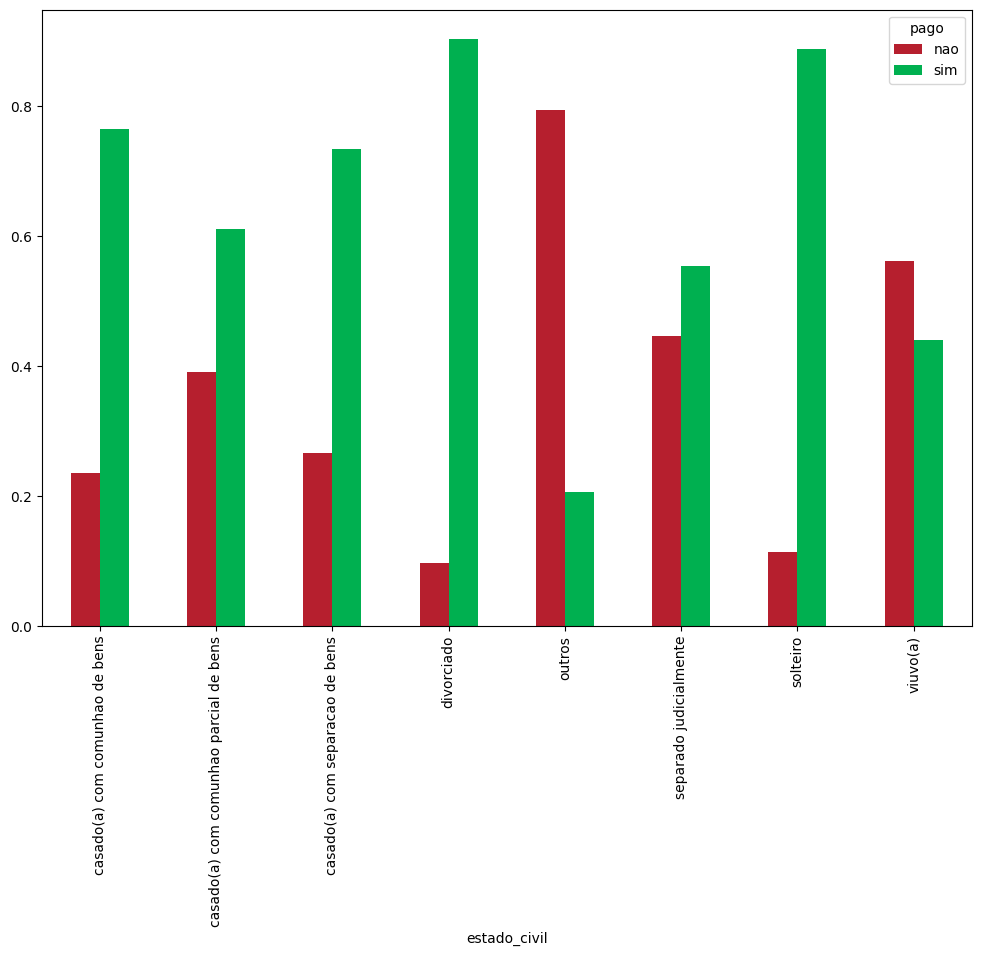

In [ ]:
display(pd.crosstab(df6['estado_civil'],df6['pago']))
display(pd.crosstab(df6['estado_civil'],df6['pago'], normalize='index'))
display(pd.crosstab(df6['estado_civil'],df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim': '#00b050'}))

## 6.5 CONTA SALARIO (Clientes com conta salário são em média 30% mais ADIMPLENTES.) (FALSO)

pago,nao,sim
conta_salario,,
N,10030,37403
S,311,822


pago,nao,sim
conta_salario,,
N,0.211456,0.788544
S,0.274492,0.725508


<Axes: xlabel='conta_salario'>

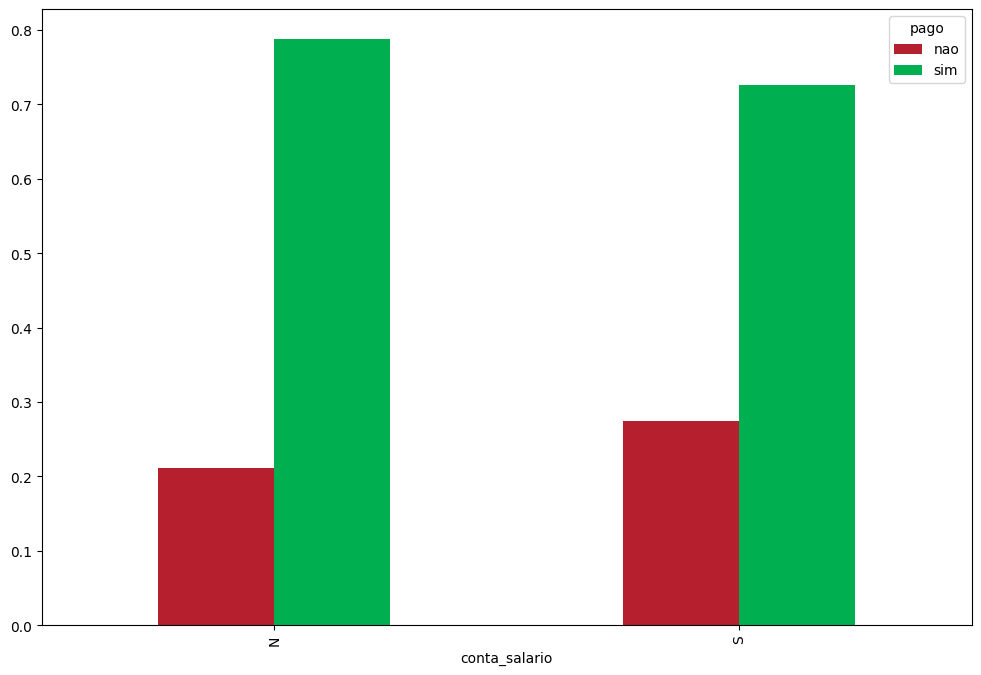

In [ ]:
display(pd.crosstab(df6['conta_salario'],df6['pago']))
display(pd.crosstab(df6['conta_salario'],df6['pago'], normalize='index'))
display(pd.crosstab(df6['conta_salario'],df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim': '#00b050'}))

## 6.6 CONTA POUPANCA (Clientes com conta poupança são em média 10% mais ADIMPLENTES.) (FALSO)

pago,nao,sim
conta_poupanca,,
N,1847,5648
S,8494,32577


pago,nao,sim
conta_poupanca,,
N,0.246431,0.753569
S,0.206813,0.793187


<Axes: xlabel='conta_poupanca'>

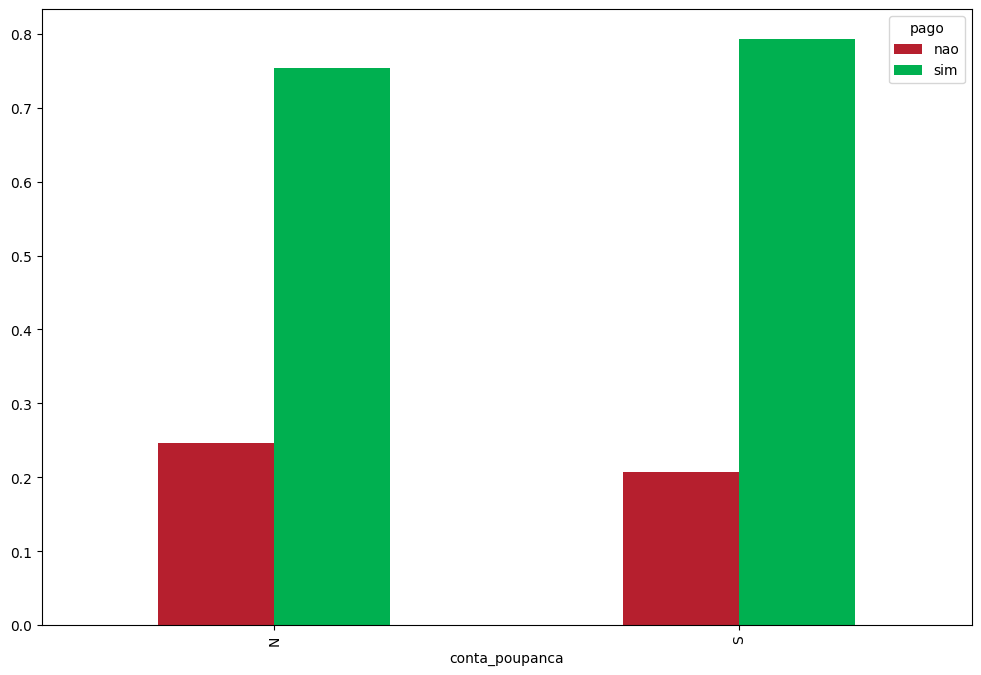

In [ ]:
display(pd.crosstab(df6['conta_poupanca'],df6['pago']))
display(pd.crosstab(df6['conta_poupanca'],df6['pago'], normalize='index'))
display(pd.crosstab(df6['conta_poupanca'],df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim': '#00b050'}))

## 6.7 CHEQUE SEM FUNDO (Clientes que já passaram cheque sem fundo são em média 15% mais INADIMPLENTES.) (VERDADEIRA)

pago,nao,sim
cheque_sem_fundo,,
N,1051,9958
S,9290,28267


pago,nao,sim
cheque_sem_fundo,,
N,0.095467,0.904533
S,0.247357,0.752643


<Axes: xlabel='cheque_sem_fundo'>

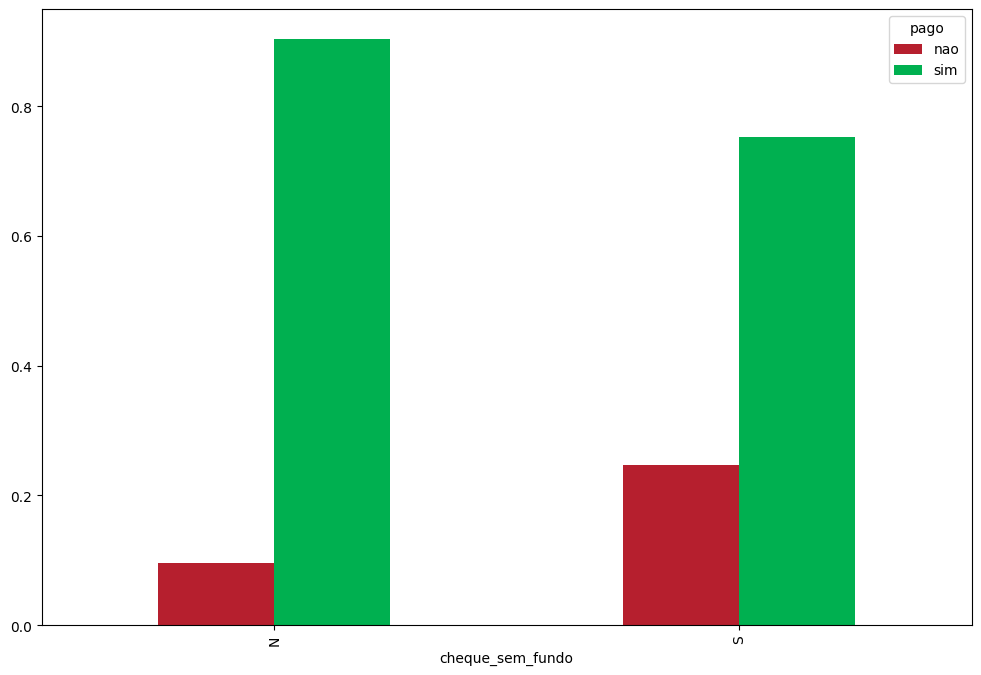

In [ ]:
display(pd.crosstab(df6['cheque_sem_fundo'],df6['pago']))
display(pd.crosstab(df6['cheque_sem_fundo'],df6['pago'], normalize='index'))
display(pd.crosstab(df6['cheque_sem_fundo'],df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim': '#00b050'}))

## 6.8 CONTA CONJUNTA (clientes que tem conta conjunta são em média 10% mais INADIMPLENTES.) (FALSO)

pago,nao,sim
conta_conjunta,,
N,10085,36489
S,256,1736


pago,nao,sim
conta_conjunta,,
N,0.216537,0.783463
S,0.128514,0.871486


<Axes: xlabel='conta_conjunta'>

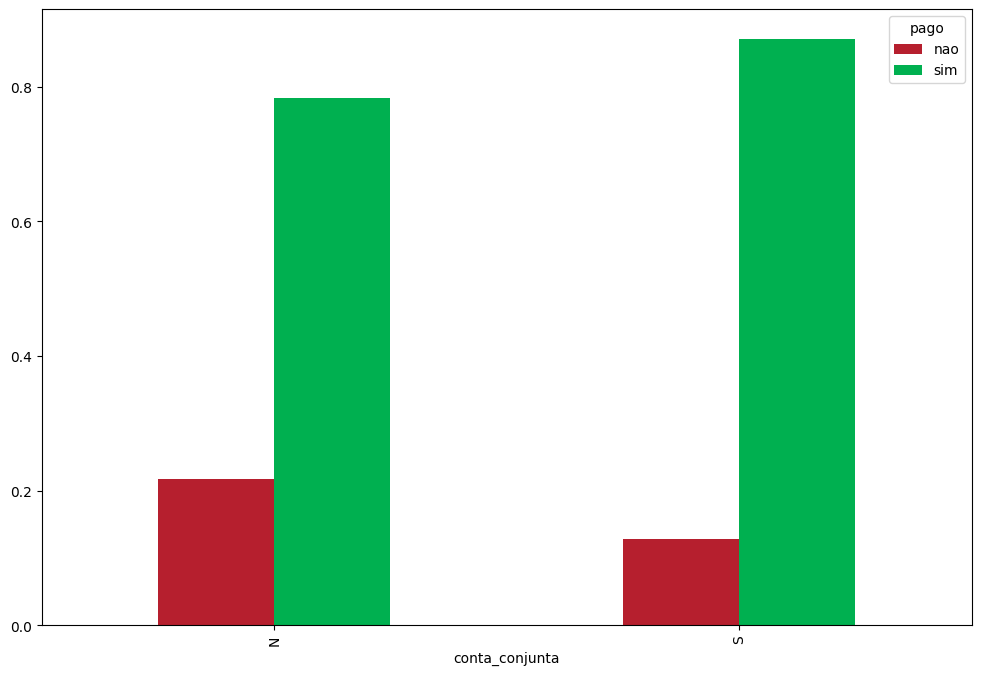

In [ ]:
display(pd.crosstab(df6['conta_conjunta'],df6['pago']))
display(pd.crosstab(df6['conta_conjunta'],df6['pago'], normalize='index'))
display(pd.crosstab(df6['conta_conjunta'],df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim': '#00b050'}))

## 6.9 EMPRESTIMO (Clientes que pegaram empréstimos de mais de RS$20000 tem tendência a ser INADIMPLENTES.) (VERDADEIRA)

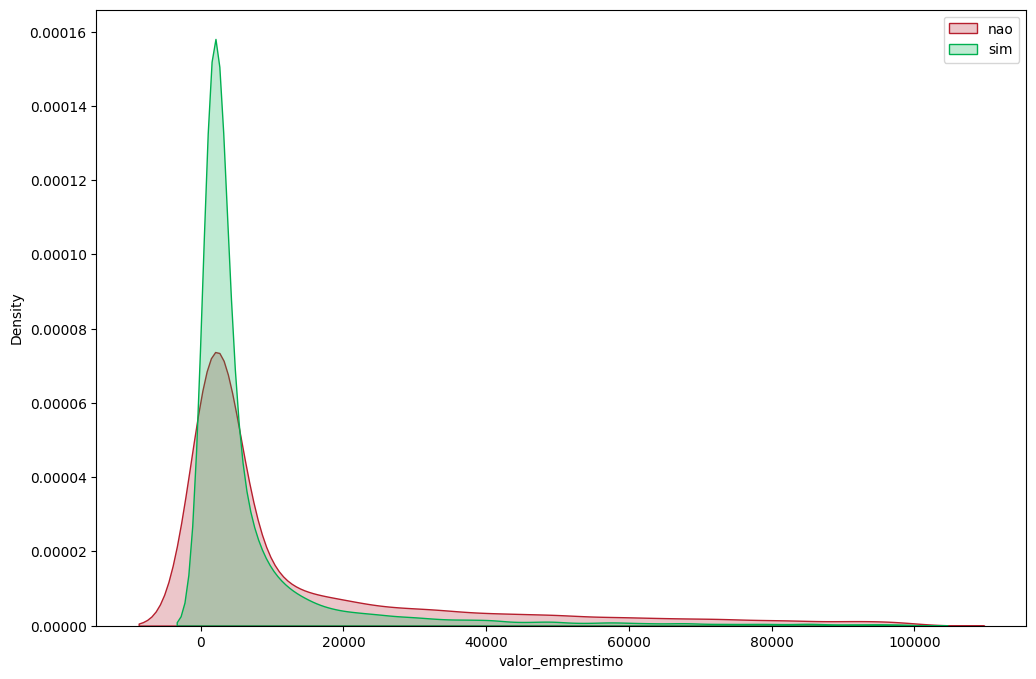

In [ ]:
aux = df6[df6['valor_emprestimo']<100000].copy()


sns.kdeplot(aux[aux['pago']=='nao']['valor_emprestimo'], label='nao', fill=True, color='#b61f2e')
sns.kdeplot(aux[aux['pago']=='sim']['valor_emprestimo'], label='sim', fill=True, color='#00b050')
plt.legend();

## 6.10 ESTADO (Clientes que moram no Estado RJ E SP tem maior percentual de ADIMPLENTE do que ES e MG.) (FALSO)

pago,nao,sim
estado,,
espirito santo,2597,9550
minas gerais,2590,9612
rio de janeiro,2592,9483
sao paulo,2562,9580


pago,nao,sim
estado,,
espirito santo,0.213798,0.786202
minas gerais,0.212260,0.787740
rio de janeiro,0.214658,0.785342
sao paulo,0.211003,0.788997


<Axes: xlabel='estado'>

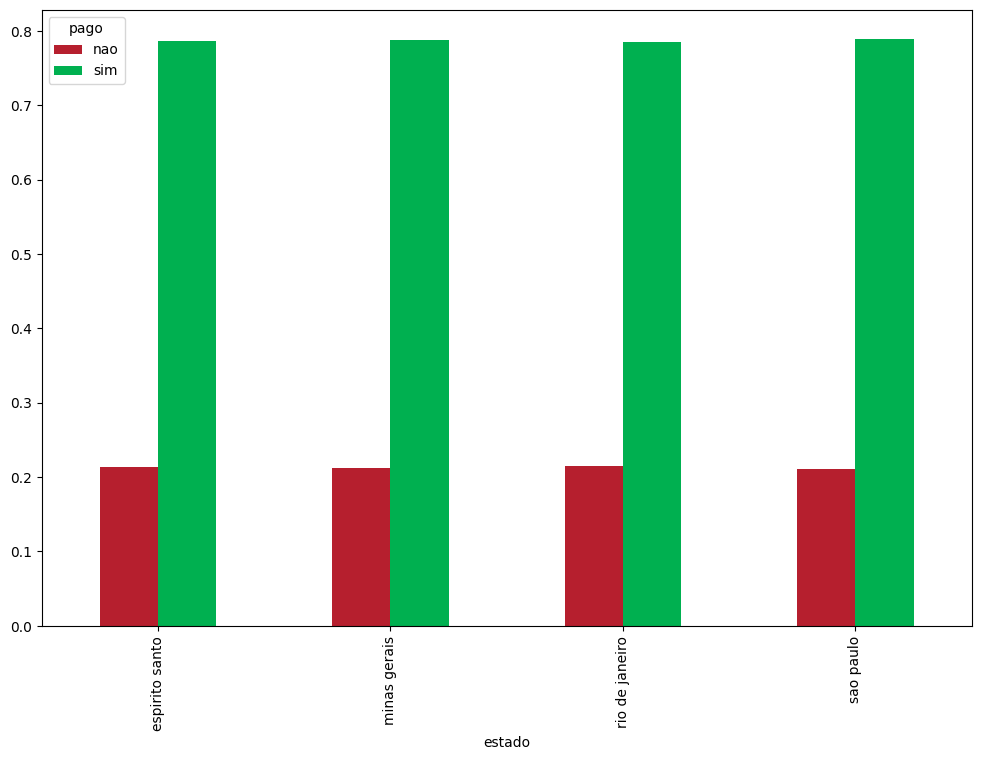

In [ ]:
display(pd.crosstab(df6['estado'],df6['pago']))
display(pd.crosstab(df6['estado'],df6['pago'], normalize='index'))
display(pd.crosstab(df6['estado'],df6['pago'], normalize='index').plot(kind='bar', color={'nao': '#b61f2e', 'sim': '#00b050'}))

# 7.0 ANALISE DE CORRELAÇÃO

In [ ]:
df7 = df6.copy()

## 7.1 NUMERICAS X NUMERICAS

In [ ]:
num_attributes  = df7.select_dtypes(include=['int32', 'int64', 'float32', 'float64'])
num_attributes  = num_attributes.drop('id', axis=1)

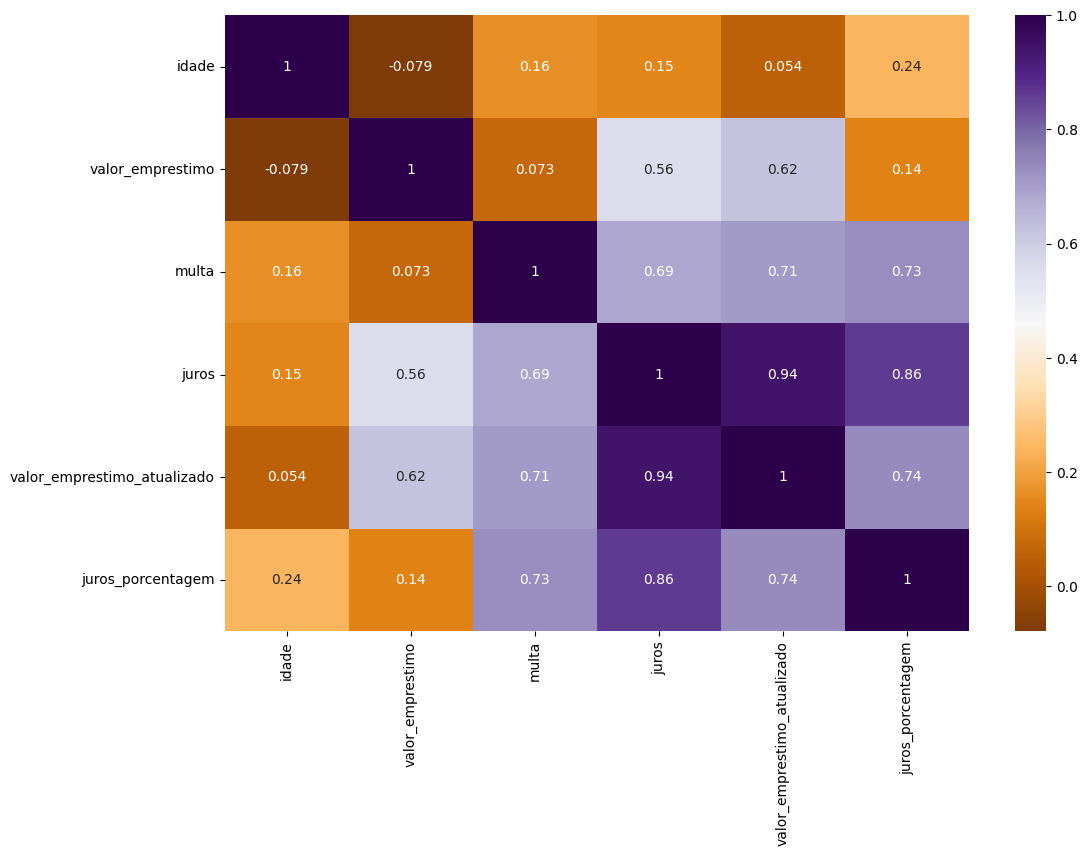

In [ ]:
sns.heatmap(num_attributes.corr('spearman'), cmap='PuOr', annot=True);

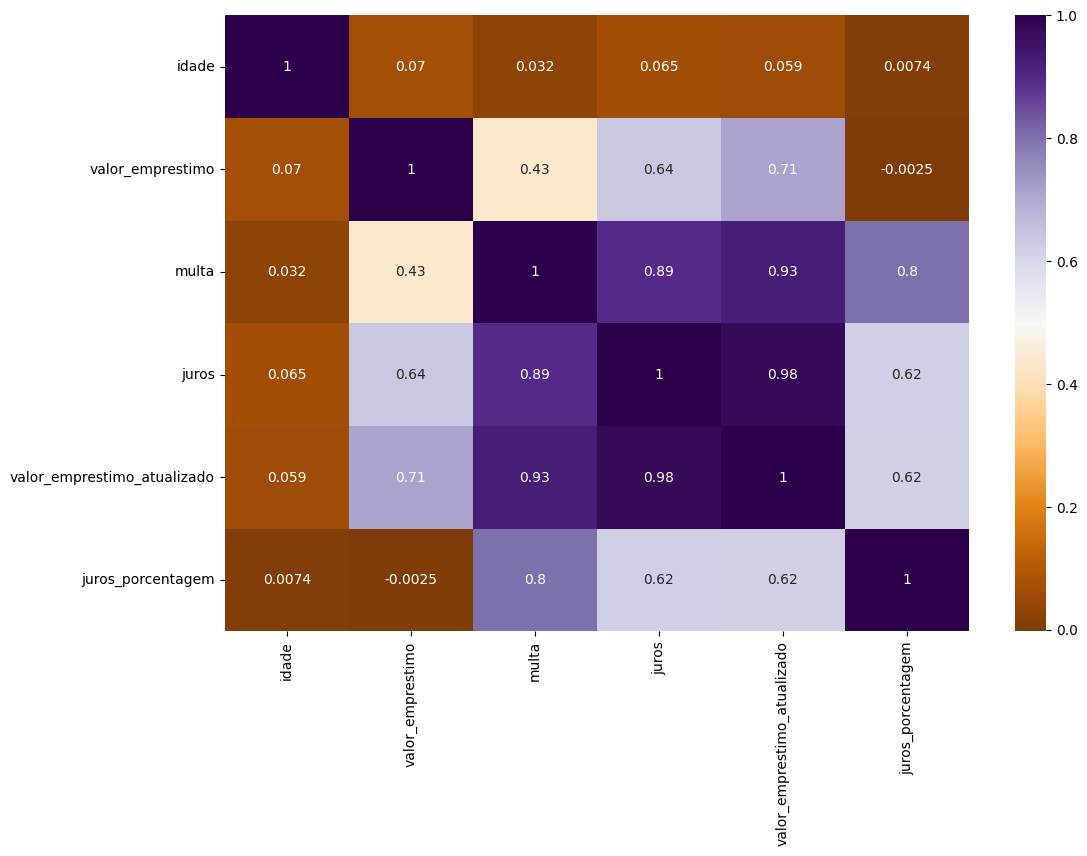

In [ ]:
sns.heatmap(num_attributes.corr('pearson'), cmap='PuOr', annot=True);

## 7.2 CATEGORICAS X CATEGORICAS

In [ ]:
from scipy import  stats as ss

def cramers_v(confusion_matrix):

    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [ ]:
cat_attributes = df7.select_dtypes( exclude=['int32','int64', 'float32', 'float64', 'datetime64[ns]'] )

cat_attributes_list = cat_attributes.columns.tolist()


corr_dict = {}

for i in range( len( cat_attributes_list ) ):

    corr_list = []

    for j in range( len( cat_attributes_list ) ):

        ref =cat_attributes_list[i]

        feat =cat_attributes_list[j]



        #correlation
        confusion_matrix = pd.crosstab(cat_attributes[ ref ], cat_attributes[ feat ])
        corr = cramers_v( confusion_matrix.values )



        #append a list

        corr_list.append( corr )



    corr_dict[ ref ] = corr_list

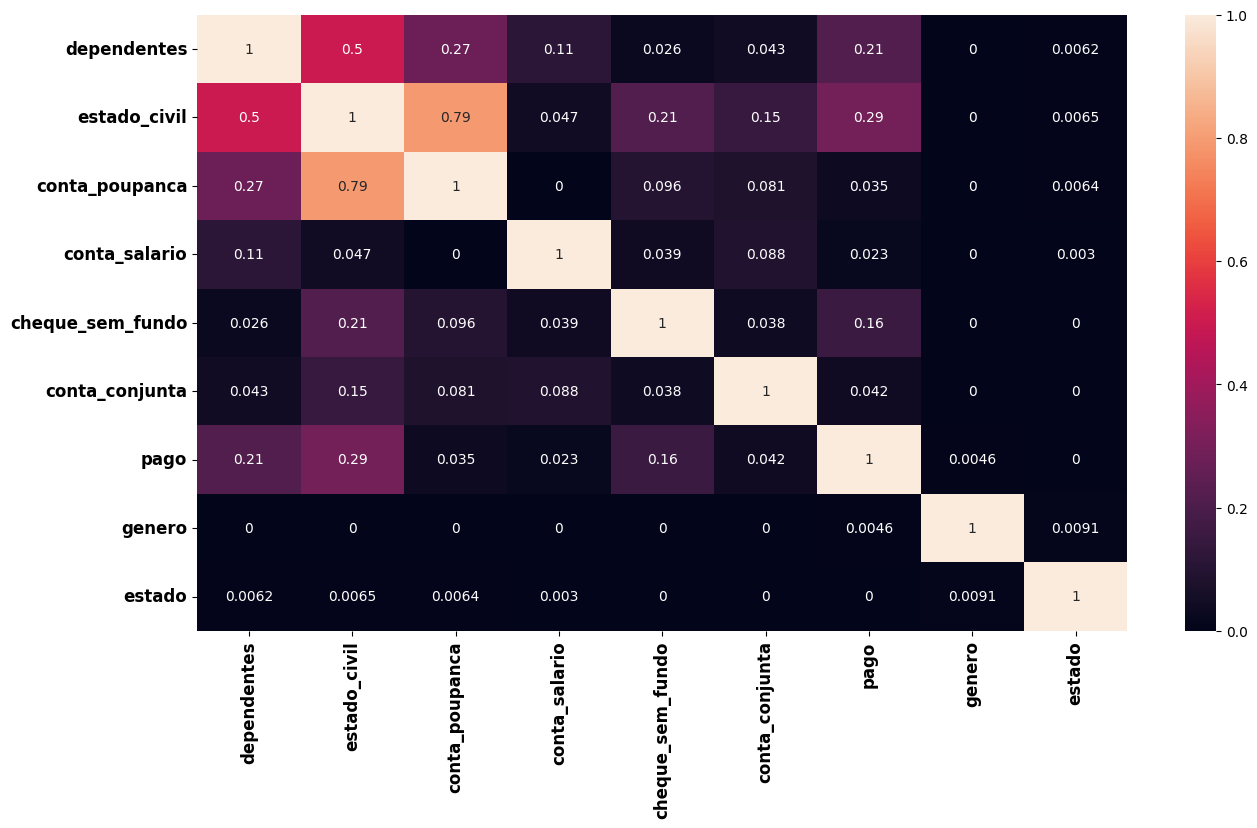

In [ ]:
d = pd.DataFrame( corr_dict )

d = d.set_index( d.columns )

plt.figure(figsize=(15,8))
sns.heatmap( d, annot=True )

plt.xticks(rotation=90, fontsize=12, weight='bold')
plt.yticks(rotation=360, fontsize=12, weight='bold');

# 8.0 SPLIT TREINO TESTE E VALIDACAO

In [ ]:
df8 = pd.read_csv(config['data']['trusted_path'])

In [ ]:
df8.head()

,dependentes,estado_civil,idade,conta_poupanca,conta_salario,cheque_sem_fundo,conta_conjunta,valor_emprestimo,multa,juros,valor_emprestimo_atualizado,pago,id,genero,estado,juros_porcentagem
0,S,solteiro,36,S,N,S,N,8174.32,263.25,5844.98,14282.55,sim,309652396,feminino,minas gerais,0.715042
1,N,solteiro,39,S,N,N,N,41775.63,1607.29,7652.26,51035.18,sim,498764591,feminino,espirito santo,0.183175
2,S,solteiro,26,S,N,N,N,522940.27,24860.40,319315.62,867116.29,sim,504868288,masculino,sao paulo,0.610616
3,N,casado(a) com comunhao de bens,23,N,N,S,N,1418.00,21472.36,2967.48,25857.84,sim,541365315,feminino,sao paulo,2.092722
4,S,solteiro,33,S,N,S,N,2078.97,19.44,46.35,2144.76,sim,563622907,masculino,espirito santo,0.022295


In [ ]:
def label_pago(x):
    if x=='sim':
        return 0
    else:
        return 1

In [ ]:
df8['pago'] = df8['pago'].apply(label_pago)

In [ ]:
train_set, test_set = train_test_split(df8, test_size = config['split']['test_size'], random_state=config['split']['seed'], stratify=df8['pago'])

In [ ]:
print(len(train_set))
print(len(test_set))

38852
9714


In [ ]:
config

{'split': {'seed': 42, 'test_size': 0.2},
 'data': {'raw_path': '../data/raw_data/raw_data.csv',
  'trusted_path': '../data/trusted_data/trusted_data.csv',
  'train_path': '../data/train_data/train_data.csv',
  'test_path': '../data/test_data/test_data.csv'},
 'imagem': {'path': '../imagens/mind map.png'}}

In [ ]:
train_set.to_csv(config['data']['train_path'], index=False)
test_set.to_csv(config['data']['test_path'], index=False)

# 9.0 FEATURE SELECTION

In [ ]:
df9 = pd.read_csv(config['data']['train_path']).drop(['id', 'multa', 'juros', 'valor_emprestimo_atualizado', 'juros_porcentagem'], axis=1).copy()

In [ ]:
df9.columns

Index(['dependentes', 'estado_civil', 'idade', 'conta_poupanca',
       'conta_salario', 'cheque_sem_fundo', 'conta_conjunta',
       'valor_emprestimo', 'pago', 'genero', 'estado'],
      dtype='object')

In [ ]:
print(df9['pago'].value_counts(normalize=True))

pago
0    0.787064
1    0.212936
Name: proportion, dtype: float64


## 9.1 LOGISTIC REGRESSION

In [ ]:
columns_select = ['dependentes', 'estado_civil', 'idade', 'conta_conjunta', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

df9_lr = df9[columns_select].copy()


### 9.1.1 SELECT VARIABLES P VALUE

In [ ]:
ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')
ce_rare.fit(df9_lr)

df9_lr = ce_rare.transform(df9_lr)

ce_rare.encoder_dict_

{'estado_civil': ['solteiro',
  'casado(a) com comunhao parcial de bens',
  'casado(a) com comunhao de bens']}

In [ ]:
x_train, x_train_2, x_test, y_test = reamostrar_lr(df9_lr, frac=0.7)

pago
0    0.525829
1    0.474171
Name: proportion, dtype: float64


In [ ]:
ss = StandardScaler()
ss.fit(x_train_2[['idade']].values)
x_train_2['idade'] = ss.transform(x_train_2[['idade']])

x_test['idade'] = ss.transform(x_test[['idade']])


yj = PowerTransformer(method='yeo-johnson', standardize=True)

yj.fit(x_train_2[['valor_emprestimo']].values)
x_train_2['valor_emprestimo'] = yj.transform(x_train_2[['valor_emprestimo']])
x_test['valor_emprestimo'] = yj.transform(x_test[['valor_emprestimo']])

/home/caetano/shap_model/venv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/caetano/shap_model/venv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/caetano/shap_model/venv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
/home/caetano/shap_model/venv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(


In [ ]:
log_reg = smf.logit("pago ~ valor_emprestimo + idade + estado_civil + conta_conjunta + dependentes + cheque_sem_fundo", data=x_train_2).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.596245
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   pago   No. Observations:                13957
Model:                          Logit   Df Residuals:                    13948
Method:                           MLE   Df Model:                            8
Date:                Wed, 31 Jan 2024   Pseudo R-squ.:                  0.1381
Time:                        20:46:44   Log-Likelihood:                -8321.8
converged:                       True   LL-Null:                       -9655.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept           

In [ ]:
yhat_lr = log_reg.predict(x_test)
predictions = list(map(round, yhat_lr))

cm = metrics.confusion_matrix(y_test, predictions)
print("confusion Matrix : '\n", cm)

confusion Matrix : '
 [[4450 1666]
 [ 588 1067]]


### 9.1.2 SELECT KBEST ANOVA (LOGISTIC REGRESSION)

In [ ]:
df9 = pd.read_csv(config['data']['train_path']).drop(['id', 'multa', 'juros', 'valor_emprestimo_atualizado', 'juros_porcentagem'], axis=1).copy()

columns_select = ['dependentes', 'estado_civil', 'idade', 'conta_conjunta', 'cheque_sem_fundo', 'valor_emprestimo', 'pago']

df9_lr = df9[columns_select].copy()

In [ ]:
x_train, x_test, y_train, y_test  = train_test_split(df9_lr.drop('pago',axis=1),
                                                     df9_lr['pago'],test_size = config['split']['test_size'], random_state=config['split']['seed'], stratify=df9_lr['pago'])

In [ ]:
ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')
ce_rare.fit(df9_lr)

df9_lr = ce_rare.transform(df9_lr)

In [ ]:
ss = StandardScaler()
ss.fit(x_train[['idade']].values)
x_train['idade'] = ss.transform(x_train[['idade']])

x_test['idade'] = ss.transform(x_test[['idade']])

yj = PowerTransformer(method='yeo-johnson', standardize=True)

yj.fit(x_train[['valor_emprestimo']].values)
x_train['valor_emprestimo'] = yj.transform(x_train[['valor_emprestimo']])
x_test['valor_emprestimo'] = yj.transform(x_test[['valor_emprestimo']])

ce_rare = RareLabelEncoder(n_categories=5, tol=0.05, variables=['estado_civil'], replace_with='outros')
ce_rare.fit(x_train)

x_train = ce_rare.transform(x_train)
x_test = ce_rare.transform(x_test)

ce_OHE = OneHotEncoder( variables = ['conta_conjunta', 'dependentes', 'estado_civil', 'cheque_sem_fundo'], drop_last=True).fit(x_train)

x_train = ce_OHE.transform(x_train)
x_test = ce_OHE.transform(x_test)


/home/caetano/shap_model/venv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/caetano/shap_model/venv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/caetano/shap_model/venv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
/home/caetano/shap_model/venv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(


k= 1 0 F1_0 = 0.823 - F1_1 = 0.433
k= 2 0 F1_0 = 0.718 - F1_1 = 0.447
k= 3 0 F1_0 = 0.731 - F1_1 = 0.45
k= 4 0 F1_0 = 0.753 - F1_1 = 0.462
k= 5 0 F1_0 = 0.768 - F1_1 = 0.48
k= 6 0 F1_0 = 0.768 - F1_1 = 0.479
k= 7 0 F1_0 = 0.773 - F1_1 = 0.481
k= 8 0 F1_0 = 0.772 - F1_1 = 0.478


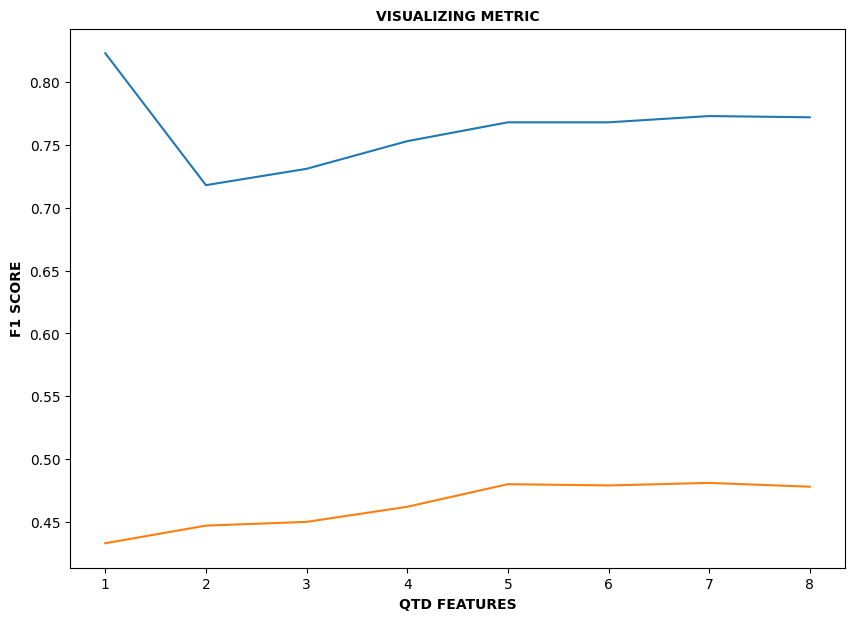

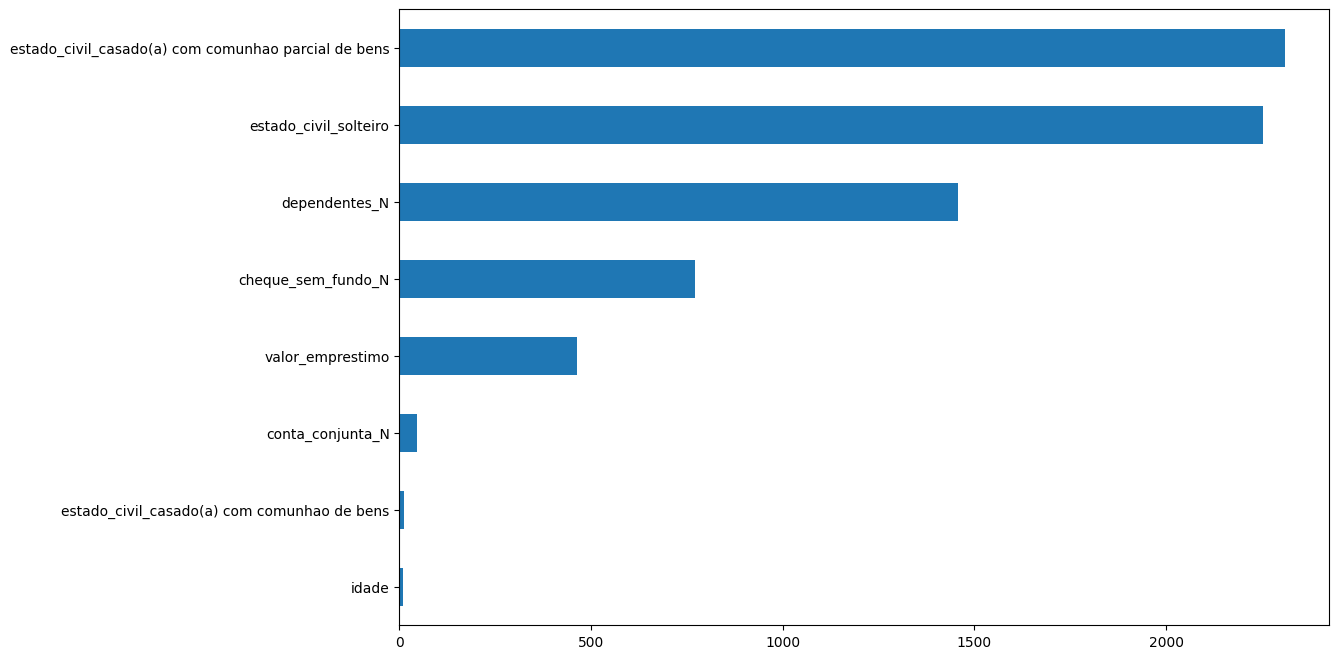

,variavel,fs_score,p_value
0,estado_civil_casado(a) com comunhao parcial de...,2310.296370,0.000000e+00
1,estado_civil_solteiro,2252.493119,0.000000e+00
2,dependentes_N,1457.194867,1.253339e-311
3,cheque_sem_fundo_N,770.260255,1.747998e-167
4,valor_emprestimo,463.627919,4.356637e-102
5,conta_conjunta_N,45.178405,1.829841e-11
6,estado_civil_casado(a) com comunhao de bens,11.793905,5.950249e-04
7,idade,9.240297,2.369434e-03


In [ ]:
fs_kbest(x_train, y_train, x_test, y_test, model = LogisticRegression(class_weight='balanced'))